<a href="https://colab.research.google.com/github/goodmot/diplom/blob/main/VKR_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Импорт библиотек для работы всего ноутбука**

In [2]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from tensorflow.keras.utils import plot_model
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Классификация текстов описания болезней**

In [4]:
!rm -R '/content/drive/texts' # Проверяем наличие папки texts. Если есть, удаляем ее

rm: cannot remove '/content/drive/texts': No such file or directory


In [5]:
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/Тексты описания болезней.zip' -d '/content/texts' 

In [6]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["Аппендицит", "Гастрит", "Гепатит", "Дуоденит", "Колит", "Панкреатит","Холицестит", "Эзофагит", "Энтерит","Язва"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

In [7]:
#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

Аппендицит Тестовая.txt добавлен в тестовую выборку
Аппендицит Обучающая.txt добавлен в обучающую выборку

Гастрит Тестовая.txt добавлен в тестовую выборку
Гастрит Обучающая.txt добавлен в обучающую выборку

Гепатит Тестовая.txt добавлен в тестовую выборку
Гепатит Обучающая.txt добавлен в обучающую выборку

Дуоденит Тестовая.txt добавлен в тестовую выборку
Дуоденит Обучающая.txt добавлен в обучающую выборку

Колит Обучающая.txt добавлен в обучающую выборку
Колит Тестовая.txt добавлен в тестовую выборку

Панкреатит Тестовая.txt добавлен в тестовую выборку
Панкреатит Обучающая.txt добавлен в обучающую выборку

Холицестит Тестовая.txt добавлен в тестовую выборку
Холицестит Обучающая.txt добавлен в обучающую выборку

Эзофагит Тестовая.txt добавлен в тестовую выборку
Эзофагит Обучающая.txt добавлен в обучающую выборку

Энтерит Обучающая.txt добавлен в обучающую выборку
Энтерит Тестовая.txt добавлен в тестовую выборку

Язва Тестовая.txt добавлен в тестовую выборку
Язва Обучающая.txt добавлен

In [8]:
print(len(trainText)) # Количество элементов в trainText
print(len(trainText[0])) # Количество символов в первом источнике в trainText

10
16044


**Обработка данных. Преобразование текстовых данных в числовые и векторные для обучения нейросети**

In [9]:
cur_time = time.time() # Засекаем текущее время
maxWordsCount = 100 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 0.04c


In [10]:
print(items) # Посмотрим 50 самых часто встречающихся слов
print("Размер словаря", len(items)) # Длина словаря

[('unknown', 1), ('в', 2), ('и', 3), ('боль', 4), ('боли', 5), ('тошнота', 6), ('рвота', 7), ('или', 8), ('живота', 9), ('при', 10), ('после', 11), ('области', 12), ('животе', 13), ('отрыжка', 14), ('с', 15), ('пищи', 16), ('слабость', 17), ('аппетита', 18), ('изжога', 19), ('во', 20), ('тела', 21), ('на', 22), ('еды', 23), ('температуры', 24), ('повышение', 25), ('может', 26), ('вздутие', 27), ('снижение', 28), ('рту', 29), ('диарея', 30), ('до', 31), ('метеоризм', 32), ('подреберье', 33), ('к', 34), ('иногда', 35), ('потеря', 36), ('правом', 37), ('приема', 38), ('стула', 39), ('части', 40), ('температура', 41), ('желудка', 42), ('верхней', 43), ('могут', 44), ('чувство', 45), ('эпигастральной', 46), ('стул', 47), ('ощущения', 48), ('время', 49), ('нарушение', 50), ('ощущение', 51), ('отсутствие', 52), ('не', 53), ('которая', 54), ('общая', 55), ('тяжесть', 56), ('кожи', 57), ('урчание', 58), ('через', 59), ('повышенная', 60), ('за', 61), ('а', 62), ('нарушения', 63), ('дефекации', 6

In [11]:
print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("Уточните слово: ")]) #протестируем словарь частотности

Уточните слово: боль
Интересующее слово имеет индекс:  4


In [12]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               ГАСТРИТ СИМПТОМЫ  диспепсии (тяжесть и чувство давления, полноты в подложечной области,
Он же в виде последовательности индексов:  [1, 86, 1, 56, 3, 45, 94, 1, 2, 1, 12, 14, 1, 6, 81, 82, 20, 29, 1, 2] 



In [13]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses): # Проходим по всем классам
  print(className[i], " "*(10-len(className[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова 

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(nClasses): #Проходим по всем классам
  print(className[i], ' '*(10-len(className[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i]) #Считаем символы
  wordsTestText += len(testWordIndexes[i]) #Считаем слова 
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
Аппендицит  16044 символов,  2179 слов
Гастрит     14604 символов,  1864 слов
Гепатит     14865 символов,  1873 слов
Дуоденит    14209 символов,  1820 слов
Колит       15784 символов,  2055 слов
Панкреатит  16762 символов,  2187 слов
Холицестит  16130 символов,  2129 слов
Эзофагит    15054 символов,  2011 слов
Энтерит     16438 символов,  2109 слов
Язва        18378 символов,  2479 слов
----
В сумме  158268  символов,  20706  слов 


Статистика по тестовым текстам:
Аппендицит  3011 символов,  417 слов
Гастрит     3748 символов,  485 слов
Гепатит     3610 символов,  459 слов
Дуоденит    3021 символов,  378 слов
Колит       3799 символов,  493 слов
Панкреатит  3452 символов,  445 слов
Холицестит  4292 символов,  588 слов
Эзофагит    4107 символов,  565 слов
Энтерит     3756 символов,  496 слов
Язва        2829 символов,  389 слов
----
В сумме  35625  символов,  4715  слов


**Создание обучающей и проверочной выборки**

In [14]:
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

In [15]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

**Подготовка данных**

In [16]:
#Задаём базовые параметры
xLen = 100 #Длина отрезка текста, по которой анализируем, в словах
step = 25 #Шаг разбиения исходного текста на обучающие векторы

In [17]:
cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(794, 100)
(794, 10)
(153, 100)
(153, 10)
Время обработки: 0.03c


In [18]:
cur_time = time.time() # Засекаем текущее время
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #П одаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100]) # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')


(794, 100)
[0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0.]
Время обработки: 0.04c


In [19]:
for i in range(100):
  print(int(i in xTrain[0]),end=' ')

0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 

**Эксперименты**

**Распознавание проверочной выборки**

In [101]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  #Для каждого из 10 классов
  #Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) #Задаем количество классов
  xTest10Classes01 = []               #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
  xTest10Classes = []                 #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:                       #Для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
    xTest10Classes.append(sample)              # Добавляем в список
    xTest10Classes01.append(tokenizer.sequences_to_matrix(sample)) #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest10Classes01 = np.array(xTest10Classes01)                     #И добавляется к нашему списку, 
  xTest10Classes = np.array(xTest10Classes)                     #И добавляется к нашему списку, 
  
  return xTest10Classes01, xTest10Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount

In [102]:
xTest10Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [103]:
l = np.array(xTest10Classes01)
np.save('xTestPredictBoW', l)
np.save('xTestPredictEmbedding', x2)

# BagOfWords

In [108]:
from re import M
#Создаём полносвязную сеть
model02 = Sequential()
#Первый полносвязный слой
model02.add(Dense(300, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model02.add(Dropout(0.25))
#Слой пакетной нормализации
model02.add(BatchNormalization())
#Выходной полносвязный слой
model02.add(Dense(10, activation='softmax'))

model02.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model02.fit(xTrain01, 
                      yTrain, 
                      epochs=100,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

Epoch 1/100
7/7 [==============================] - 1s 62ms/step - loss: 2.4588 - accuracy: 0.2091 - val_loss: 2.0843 - val_accuracy: 0.3922
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 1.3564 - accuracy: 0.5516 - val_loss: 1.8701 - val_accuracy: 0.4967
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.7990 - accuracy: 0.7771 - val_loss: 1.7071 - val_accuracy: 0.5752
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 0.5315 - accuracy: 0.8451 - val_loss: 1.5893 - val_accuracy: 0.6078
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3710 - accuracy: 0.9005 - val_loss: 1.5049 - val_accuracy: 0.6667
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.2612 - accuracy: 0.9496 - val_loss: 1.4355 - val_accuracy: 0.6797
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.2020 - accuracy: 0.9584 - val_loss: 1.3733 - val_accuracy: 0.6928
Epoch 8/100
7/7 [========

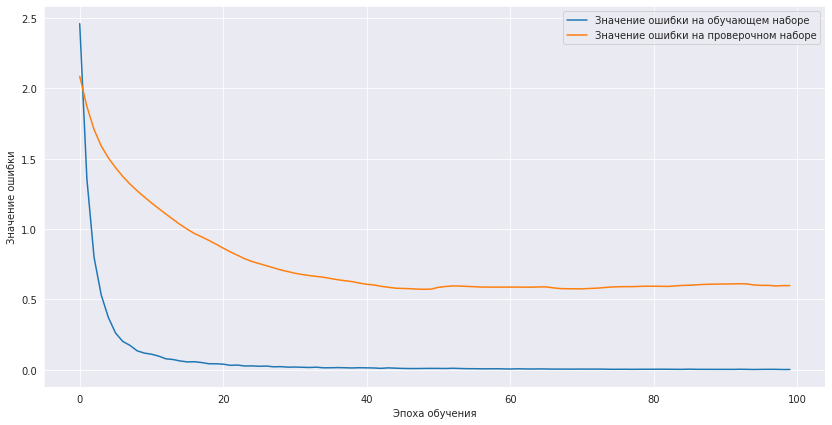

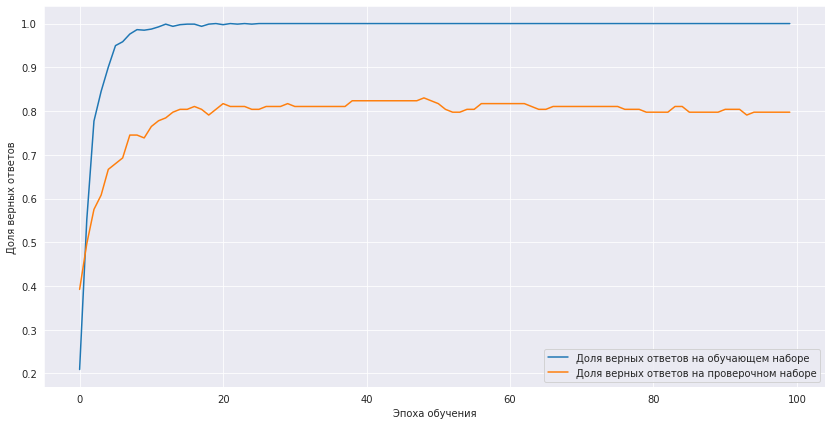

In [109]:
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [110]:
pred = recognizeMultiClass(model02, xTest10Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: Аппендицит 84% сеть отнесла к классу Аппендицит Это ПРАВИЛЬНЫЙ ответ!
Класс: Гастрит    56% сеть отнесла к классу Гастрит    Это ПРАВИЛЬНЫЙ ответ!
Класс: Гепатит    100% сеть отнесла к классу Гепатит   Это ПРАВИЛЬНЫЙ ответ!
Класс: Дуоденит   50% сеть отнесла к классу Дуоденит   Это ПРАВИЛЬНЫЙ ответ!
Класс: Колит      81% сеть отнесла к классу Колит      Это ПРАВИЛЬНЫЙ ответ!
Класс: Панкреатит 42% сеть отнесла к классу Панкреатит Это ПРАВИЛЬНЫЙ ответ!
Класс: Холицестит 80% сеть отнесла к классу Холицестит Это ПРАВИЛЬНЫЙ ответ!
Класс: Эзофагит   94% сеть отнесла к классу Эзофагит   Это ПРАВИЛЬНЫЙ ответ!
Класс: Энтерит    100% сеть отнесла к классу Энтерит   Это ПРАВИЛЬНЫЙ ответ!
Класс: Язва       100% сеть отнесла к классу Язва      Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 79%



In [111]:
model02.compile(optimizer=Adam(0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history2 = model02.fit(xTrain01, 
                      yTrain, 
                      epochs=100,
                      batch_size=64,
                      validation_data=(xTest01, yTest))

Epoch 1/100
13/13 [==============================] - 1s 19ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.6058 - val_accuracy: 0.7974
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.6037 - val_accuracy: 0.7974
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.6028 - val_accuracy: 0.7908
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.6031 - val_accuracy: 0.7908
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.6040 - val_accuracy: 0.7974
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.6093 - val_accuracy: 0.7974
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.6106 - val_accuracy: 0.7974
Epoch 8/100


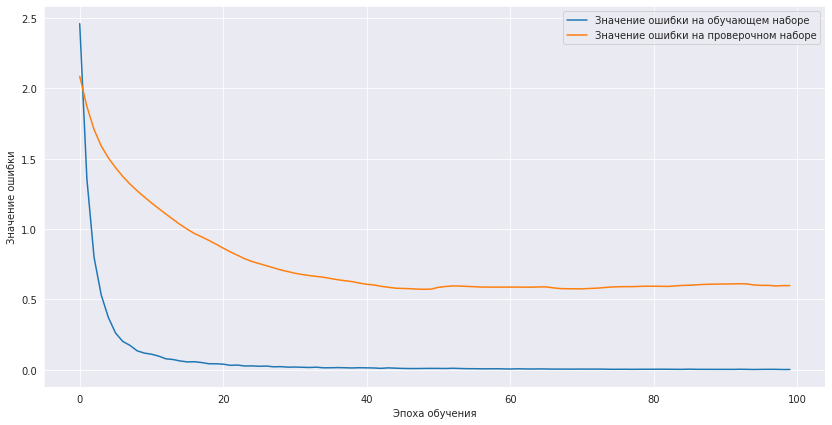

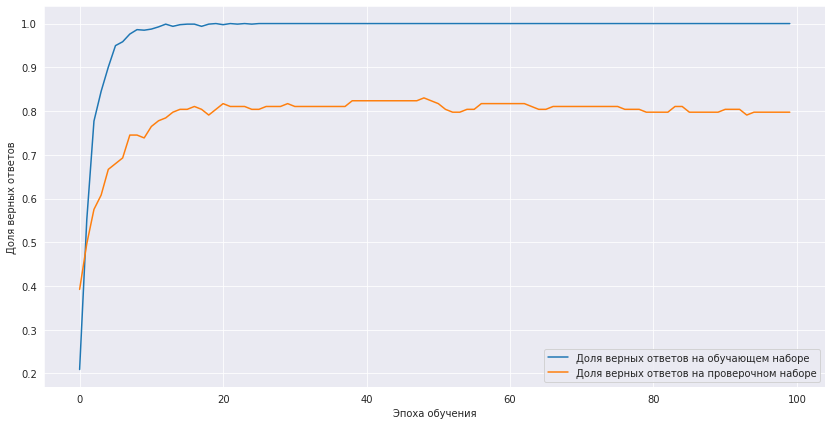

In [112]:
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [113]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model02, xTest10Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: Аппендицит 84% сеть отнесла к классу Аппендицит Это ПРАВИЛЬНЫЙ ответ!
Класс: Гастрит    56% сеть отнесла к классу Гастрит    Это ПРАВИЛЬНЫЙ ответ!
Класс: Гепатит    100% сеть отнесла к классу Гепатит   Это ПРАВИЛЬНЫЙ ответ!
Класс: Дуоденит   50% сеть отнесла к классу Дуоденит   Это ПРАВИЛЬНЫЙ ответ!
Класс: Колит      87% сеть отнесла к классу Колит      Это ПРАВИЛЬНЫЙ ответ!
Класс: Панкреатит 42% сеть отнесла к классу Панкреатит Это ПРАВИЛЬНЫЙ ответ!
Класс: Холицестит 80% сеть отнесла к классу Холицестит Это ПРАВИЛЬНЫЙ ответ!
Класс: Эзофагит   89% сеть отнесла к классу Эзофагит   Это ПРАВИЛЬНЫЙ ответ!
Класс: Энтерит    100% сеть отнесла к классу Энтерит   Это ПРАВИЛЬНЫЙ ответ!
Класс: Язва       100% сеть отнесла к классу Язва      Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 79%



In [29]:
model02.save_weights('modelweights.h5')
model02.save('model2.h5')


# Embedding + Dense

In [114]:
#Создаём сеть с Embedding слоем
model03 = Sequential()
model03.add(Embedding(maxWordsCount, 50, input_length=xLen))
model03.add(SpatialDropout1D(0.2))
model03.add(Flatten())
model03.add(BatchNormalization())
model03.add(Dense(200, activation="relu"))
model03.add(Dropout(0.2))
model03.add(BatchNormalization())
model03.add(Dense(10, activation='softmax'))

model03.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [31]:
model03.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           5000      
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 50)          0         
 ropout1D)                                                       
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 5000)             20000     
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 200)               1000200   
                                                                 
 dropout_1 (Dropout)         (None, 200)              

In [115]:
#Обучаем сеть на xTrain
history = model03.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(xTest, yTest))

Epoch 1/100
13/13 [==============================] - 1s 38ms/step - loss: 3.0098 - accuracy: 0.1348 - val_loss: 2.2980 - val_accuracy: 0.1111
Epoch 2/100
13/13 [==============================] - 0s 22ms/step - loss: 0.7502 - accuracy: 0.7632 - val_loss: 2.3228 - val_accuracy: 0.0915
Epoch 3/100
13/13 [==============================] - 0s 23ms/step - loss: 0.2596 - accuracy: 0.9584 - val_loss: 2.3546 - val_accuracy: 0.0980
Epoch 4/100
13/13 [==============================] - 0s 22ms/step - loss: 0.1220 - accuracy: 0.9899 - val_loss: 2.3906 - val_accuracy: 0.0980
Epoch 5/100
13/13 [==============================] - 0s 22ms/step - loss: 0.0791 - accuracy: 0.9987 - val_loss: 2.4207 - val_accuracy: 0.1046
Epoch 6/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0549 - accuracy: 0.9975 - val_loss: 2.4540 - val_accuracy: 0.0784
Epoch 7/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0426 - accuracy: 1.0000 - val_loss: 2.4849 - val_accuracy: 0.0915
Epoch 

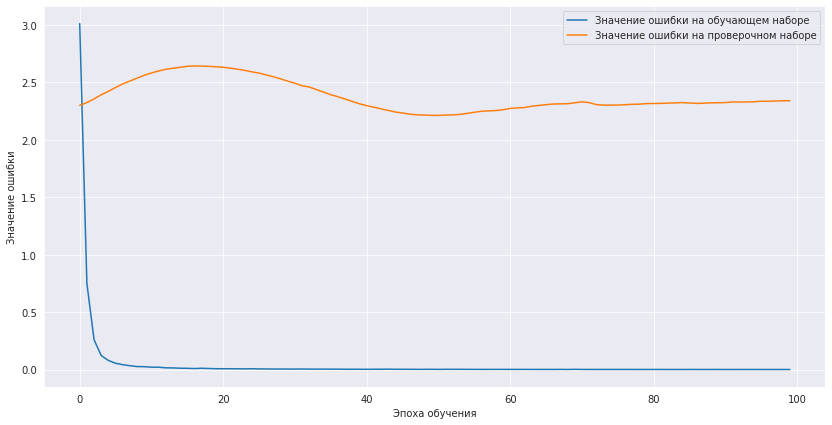

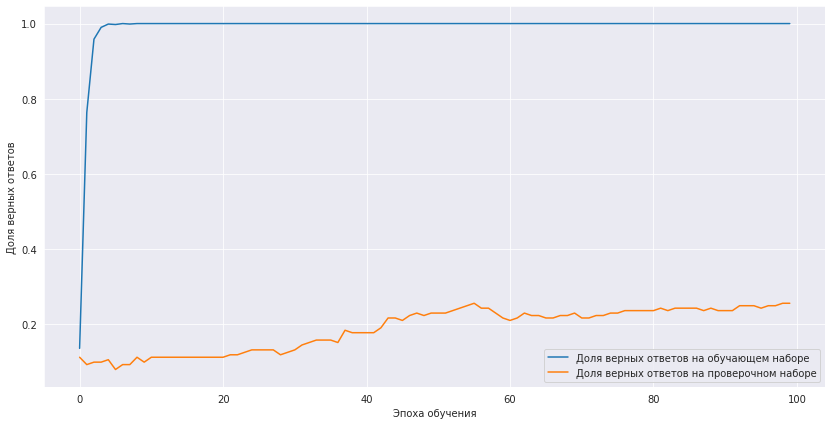

In [116]:
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model03.save_weights('model.h5')

In [ ]:
model03.load_weights('model.h5')

In [117]:
#Проверяем результаты работы Ebedding сети
_, xTest10Classes = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
pred = recognizeMultiClass(model03, xTest10Classes, "Embedding + Dense")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


НЕЙРОНКА:  Embedding + Dense

Класс: Аппендицит 23% сеть отнесла к классу Аппендицит Это ПРАВИЛЬНЫЙ ответ!
Класс: Гастрит    18% сеть отнесла к классу Язва       Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Гепатит    20% сеть отнесла к классу Холицестит Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Дуоденит   0% сеть отнесла к классу Панкреатит  Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Колит      31% сеть отнесла к классу Колит      Это ПРАВИЛЬНЫЙ ответ!
Класс: Панкреатит 14% сеть отнесла к классу Аппендицит Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Холицестит 20% сеть отнесла к классу Гепатит    Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Эзофагит   57% сеть отнесла к классу Эзофагит   Это ПРАВИЛЬНЫЙ ответ!
Класс: Энтерит    25% сеть отнесла к классу Колит      Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Язва       33% сеть отнесла к классу Язва       Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 25%



**output_dim = 200**

In [118]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 200, input_length=xLen))
modelE.add(SpatialDropout1D(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(10, activation='softmax'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [37]:
modelE.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 200)          20000     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 100, 200)         0         
 lDropout1D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 batch_normalization_3 (Batc  (None, 20000)            80000     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 200)               4000200   
                                                                 
 dropout_2 (Dropout)         (None, 200)              

In [119]:
#Обучаем сеть на xTrain
history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(xTest, yTest))

Epoch 1/100
13/13 [==============================] - 2s 86ms/step - loss: 3.2078 - accuracy: 0.1889 - val_loss: 2.2846 - val_accuracy: 0.1176
Epoch 2/100
13/13 [==============================] - 1s 71ms/step - loss: 0.3309 - accuracy: 0.9043 - val_loss: 2.2946 - val_accuracy: 0.1242
Epoch 3/100
13/13 [==============================] - 1s 70ms/step - loss: 0.1296 - accuracy: 0.9861 - val_loss: 2.3197 - val_accuracy: 0.1111
Epoch 4/100
13/13 [==============================] - 1s 75ms/step - loss: 0.0677 - accuracy: 0.9975 - val_loss: 2.3473 - val_accuracy: 0.1307
Epoch 5/100
13/13 [==============================] - 2s 120ms/step - loss: 0.0470 - accuracy: 0.9987 - val_loss: 2.3698 - val_accuracy: 0.1373
Epoch 6/100
13/13 [==============================] - 1s 103ms/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 2.3907 - val_accuracy: 0.1307
Epoch 7/100
13/13 [==============================] - 2s 117ms/step - loss: 0.0253 - accuracy: 1.0000 - val_loss: 2.4096 - val_accuracy: 0.1373
Epo

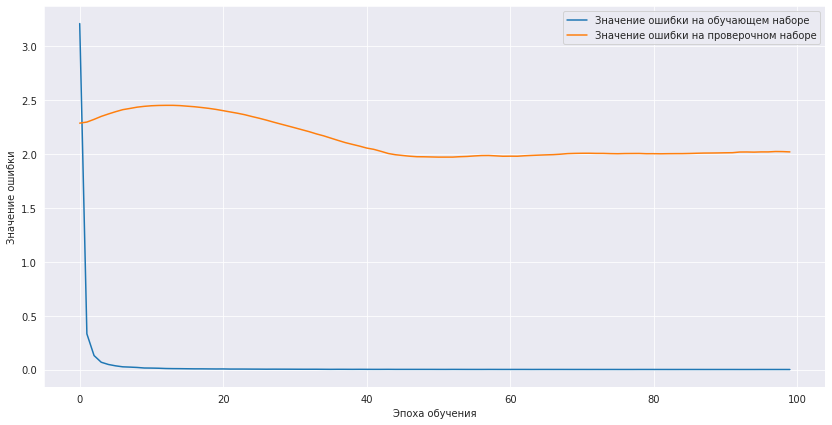

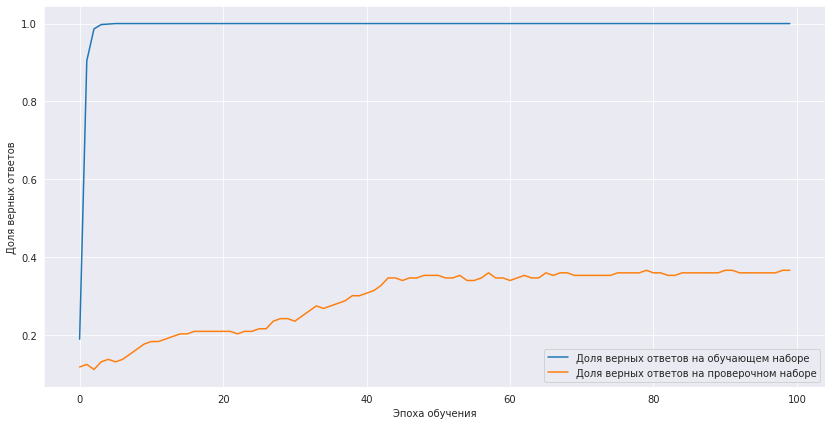

In [120]:
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [121]:
#Проверяем результаты работы Ebedding сети
_, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
pred = recognizeMultiClass(modelE, xTest6Classes, "Embedding + Dense")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


НЕЙРОНКА:  Embedding + Dense

Класс: Аппендицит 7% сеть отнесла к классу Панкреатит  Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Гастрит    37% сеть отнесла к классу Эзофагит   Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Гепатит    26% сеть отнесла к классу Гепатит    Это ПРАВИЛЬНЫЙ ответ!
Класс: Дуоденит   8% сеть отнесла к классу Эзофагит    Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Колит      37% сеть отнесла к классу Энтерит    Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Панкреатит 28% сеть отнесла к классу Гастрит    Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Холицестит 50% сеть отнесла к классу Холицестит Это ПРАВИЛЬНЫЙ ответ!
Класс: Эзофагит   68% сеть отнесла к классу Эзофагит   Это ПРАВИЛЬНЫЙ ответ!
Класс: Энтерит    25% сеть отнесла к классу Колит      Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Язва       58% сеть отнесла к классу Язва       Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 36%



In [122]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 200, input_length=xLen))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(BatchNormalization())
modelE.add(Dense(10, activation='softmax'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [42]:
modelE.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 200)          20000     
                                                                 
 flatten_2 (Flatten)         (None, 20000)             0         
                                                                 
 batch_normalization_5 (Batc  (None, 20000)            80000     
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 200)               4000200   
                                                                 
 batch_normalization_6 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 10)               

In [123]:
#Обучаем сеть на xTrain
history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(xTest, yTest))

Epoch 1/100
13/13 [==============================] - 3s 86ms/step - loss: 3.6338 - accuracy: 0.1436 - val_loss: 2.2980 - val_accuracy: 0.1765
Epoch 2/100
13/13 [==============================] - 1s 68ms/step - loss: 0.1562 - accuracy: 0.9736 - val_loss: 2.2784 - val_accuracy: 0.2026
Epoch 3/100
13/13 [==============================] - 1s 69ms/step - loss: 0.0513 - accuracy: 0.9987 - val_loss: 2.2770 - val_accuracy: 0.1830
Epoch 4/100
13/13 [==============================] - 1s 70ms/step - loss: 0.0285 - accuracy: 1.0000 - val_loss: 2.2792 - val_accuracy: 0.1634
Epoch 5/100
13/13 [==============================] - 1s 69ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 2.2824 - val_accuracy: 0.1569
Epoch 6/100
13/13 [==============================] - 1s 69ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 2.2848 - val_accuracy: 0.1503
Epoch 7/100
13/13 [==============================] - 1s 68ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 2.2864 - val_accuracy: 0.1634
Epoch 

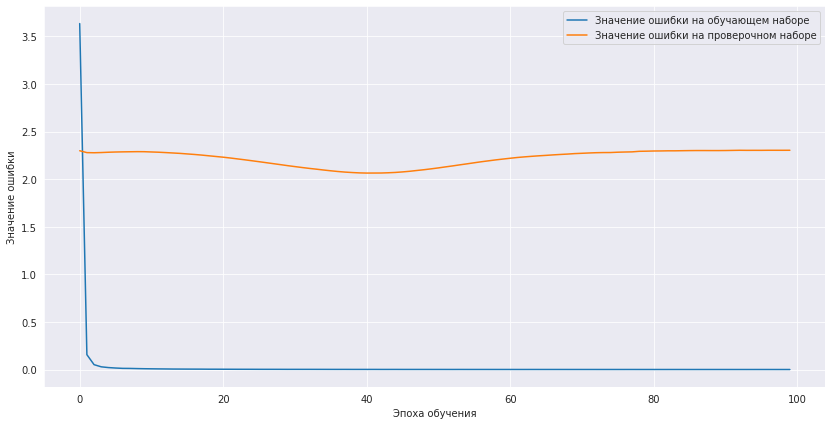

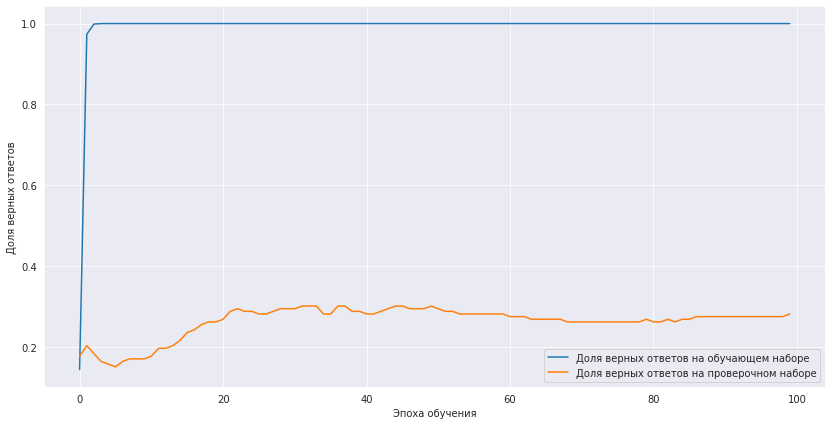

In [124]:
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [125]:
#Проверяем результаты работы Ebedding сети
_, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
pred = recognizeMultiClass(modelE, xTest6Classes, "Embedding + Dense")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


НЕЙРОНКА:  Embedding + Dense

Класс: Аппендицит 15% сеть отнесла к классу Дуоденит   Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Гастрит    37% сеть отнесла к классу Гастрит    Это ПРАВИЛЬНЫЙ ответ!
Класс: Гепатит    26% сеть отнесла к классу Гепатит    Это ПРАВИЛЬНЫЙ ответ!
Класс: Дуоденит   0% сеть отнесла к классу Эзофагит    Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Колит      31% сеть отнесла к классу Энтерит    Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Панкреатит 0% сеть отнесла к классу Язва        Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Холицестит 30% сеть отнесла к классу Холицестит Это ПРАВИЛЬНЫЙ ответ!
Класс: Эзофагит   63% сеть отнесла к классу Эзофагит   Это ПРАВИЛЬНЫЙ ответ!
Класс: Энтерит    25% сеть отнесла к классу Колит      Это НЕПРАВИЛЬНЫЙ ответ!
Класс: Язва       33% сеть отнесла к классу Гастрит    Это НЕПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 28%



**Распознавание проверочной выборки**

In [126]:
#Задаём базовые параметры
xLen = 100 #Длина отрезка текста, по которой анализируем, в словах
step = 25 #Шаг разбиения исходного текста на обучающие векторы

Перепишем функцию распознавания выборки

In [127]:
# Расспознаём тестовую выборку и выводим результаты
##########################
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)
    
    # Считаем процент распознавания каждого класса за каждый
    # Получам матрицу 6 на 6
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
  # Выводим вредний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount

xTest10Classes01, xTest10Classes = createTestMultiClasses(testWordIndexes, xLen, step) # подгоним форму тестовых классов под функцию recognizeMultiClass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


# Эксперименты

# Simple RNN

# **Иссл. №1**

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 100, 5)            500       
                                                                 
 spatial_dropout1d_20 (Spati  (None, 100, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_33 (Bat  (None, 100, 5)           20        
 chNormalization)                                                
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 4)                 40        
                                                                 
 dropout_17 (Dropout)        (None, 4)                 0         
                                                                 
 dense_38 (Dense)            (None, 10)              

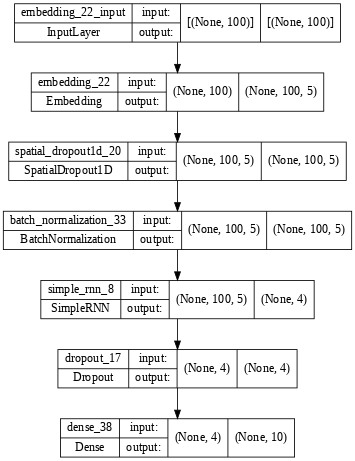

In [128]:
modelSimpleRNN = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelSimpleRNN.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelSimpleRNN.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelSimpleRNN.add(BatchNormalization()) # добавляем слой нормализации данных
modelSimpleRNN.add(SimpleRNN(4))
modelSimpleRNN.add(Dropout(0.2))
modelSimpleRNN.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelSimpleRNN.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelSimpleRNN.summary() # Выводим summary модели
print()
plot_model(modelSimpleRNN, dpi=60, show_shapes=True) # Выводим схему модели

In [129]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelSimpleRNN.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 4s 117ms/step - loss: 2.3560 - accuracy: 0.1134 - val_loss: 2.2989 - val_accuracy: 0.1438
Epoch 2/100
7/7 [==============================] - 0s 28ms/step - loss: 2.3452 - accuracy: 0.1297 - val_loss: 2.2987 - val_accuracy: 0.1438
Epoch 3/100
7/7 [==============================] - 0s 26ms/step - loss: 2.3215 - accuracy: 0.1184 - val_loss: 2.3112 - val_accuracy: 0.0850
Epoch 4/100
7/7 [==============================] - 0s 28ms/step - loss: 2.2981 - accuracy: 0.1398 - val_loss: 2.3120 - val_accuracy: 0.0850
Epoch 5/100
7/7 [==============================] - 0s 28ms/step - loss: 2.2958 - accuracy: 0.1423 - val_loss: 2.2972 - val_accuracy: 0.0784
Epoch 6/100
7/7 [==============================] - 0s 26ms/step - loss: 2.2631 - accuracy: 0.1574 - val_loss: 2.2952 - val_accuracy: 0.1503
Epoch 7/100
7/7 [==============================] - 0s 28ms/step - loss: 2.2750 - accuracy: 0.1524 - val_loss: 2.2919 - val_accuracy: 0.1176
Epoch 8/100
7/7 [==

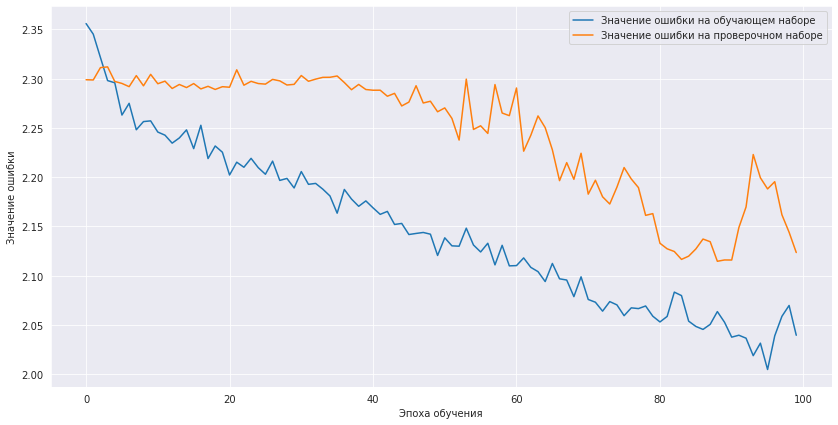

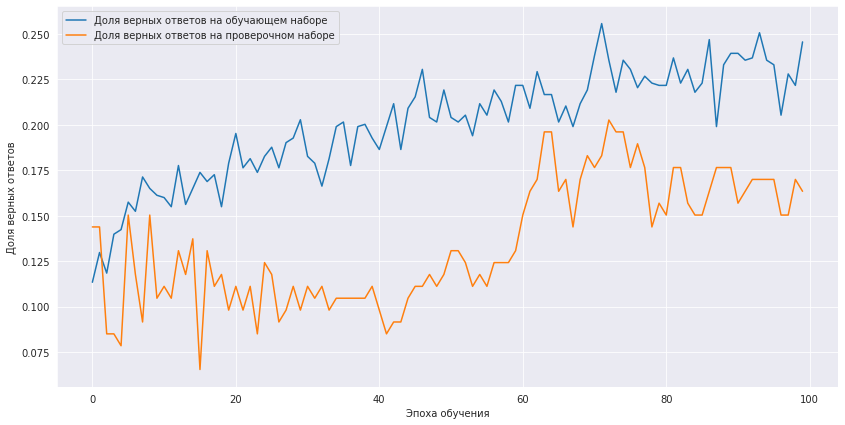

In [130]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [131]:
pred = recognizeMultiClass(modelSimpleRNN, xTest10Classes, "SimpleRNN") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  SimpleRNN

Аппендицит  распознано  0 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  18 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  0 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  25 % сеть считает, что это  Энтерит ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  21 % сеть считает, что это  Энтерит ,  распознано НЕ ВЕРНО!
Холицестит  распознано  0 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  26 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Энтерит  распознано  37 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Язва  распознано  33 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  16 %



# **Иссл. №2**

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 100, 5)            500       
                                                                 
 spatial_dropout1d_21 (Spati  (None, 100, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_34 (Bat  (None, 100, 5)           20        
 chNormalization)                                                
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 20)                520       
                                                                 
 dropout_18 (Dropout)        (None, 20)                0         
                                                                 
 dense_39 (Dense)            (None, 10)              

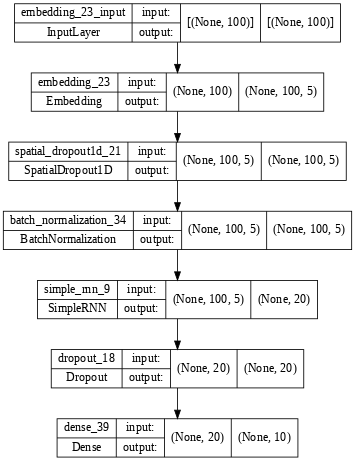

In [132]:
modelSimpleRNN_2 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelSimpleRNN_2.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelSimpleRNN_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelSimpleRNN_2.add(BatchNormalization()) # добавляем слой нормализации данных
modelSimpleRNN_2.add(SimpleRNN(20))
modelSimpleRNN_2.add(Dropout(0.2))
modelSimpleRNN_2.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelSimpleRNN_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelSimpleRNN_2.summary() # Выводим summary модели
print()
plot_model(modelSimpleRNN_2, dpi=60, show_shapes=True) # Выводим схему модели

In [133]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelSimpleRNN_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 3s 75ms/step - loss: 2.4143 - accuracy: 0.1159 - val_loss: 2.3166 - val_accuracy: 0.0980
Epoch 2/100
7/7 [==============================] - 0s 27ms/step - loss: 2.4089 - accuracy: 0.0995 - val_loss: 2.3083 - val_accuracy: 0.1242
Epoch 3/100
7/7 [==============================] - 0s 29ms/step - loss: 2.3568 - accuracy: 0.1247 - val_loss: 2.3073 - val_accuracy: 0.1176
Epoch 4/100
7/7 [==============================] - 0s 30ms/step - loss: 2.3379 - accuracy: 0.1373 - val_loss: 2.3077 - val_accuracy: 0.1242
Epoch 5/100
7/7 [==============================] - 0s 31ms/step - loss: 2.2964 - accuracy: 0.1385 - val_loss: 2.3055 - val_accuracy: 0.1242
Epoch 6/100
7/7 [==============================] - 0s 27ms/step - loss: 2.2710 - accuracy: 0.1650 - val_loss: 2.3090 - val_accuracy: 0.1176
Epoch 7/100
7/7 [==============================] - 0s 28ms/step - loss: 2.2545 - accuracy: 0.1751 - val_loss: 2.3115 - val_accuracy: 0.0980
Epoch 8/100
7/7 [===

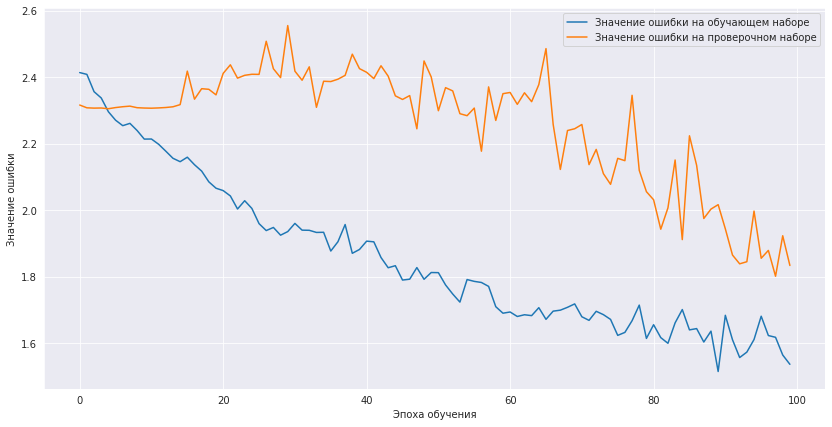

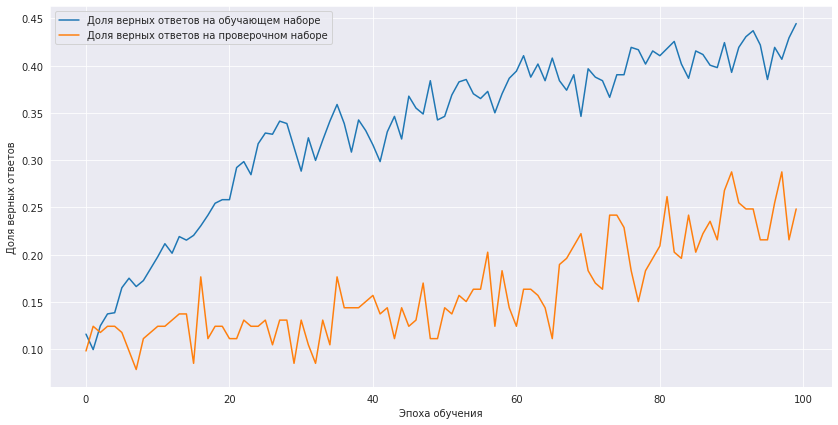

In [134]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [135]:
pred = recognizeMultiClass(modelSimpleRNN_2, xTest10Classes, "SimpleRNN") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  SimpleRNN

Аппендицит  распознано  38 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  33 % сеть считает, что это  Холицестит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  8 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  25 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  0 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Холицестит  распознано  30 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  26 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Энтерит  распознано  18 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Язва  распознано  75 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  24 %



# **Иссл. №3**

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 100, 100)          10000     
                                                                 
 spatial_dropout1d_22 (Spati  (None, 100, 100)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_35 (Bat  (None, 100, 100)         400       
 chNormalization)                                                
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 20)                2420      
                                                                 
 dropout_19 (Dropout)        (None, 20)                0         
                                                                 
 dense_40 (Dense)            (None, 10)              

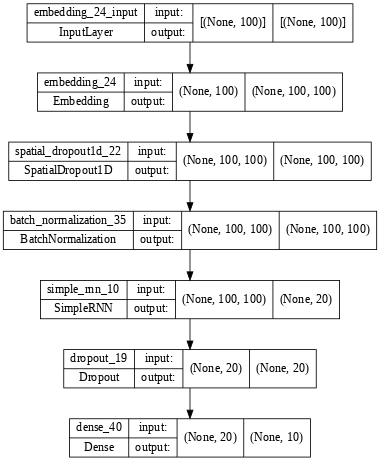

In [136]:
modelSimpleRNN_3 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelSimpleRNN_3.add(Embedding(maxWordsCount, 100, input_length=xLen))

modelSimpleRNN_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelSimpleRNN_3.add(BatchNormalization()) # добавляем слой нормализации данных
modelSimpleRNN_3.add(SimpleRNN(20))
modelSimpleRNN_3.add(Dropout(0.2))
modelSimpleRNN_3.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelSimpleRNN_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelSimpleRNN_3.summary() # Выводим summary модели
print()
plot_model(modelSimpleRNN_3, dpi=60, show_shapes=True) # Выводим схему модели

In [137]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelSimpleRNN_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 3s 104ms/step - loss: 2.5853 - accuracy: 0.1071 - val_loss: 2.3193 - val_accuracy: 0.1176
Epoch 2/100
7/7 [==============================] - 0s 57ms/step - loss: 2.3863 - accuracy: 0.1247 - val_loss: 2.3229 - val_accuracy: 0.0850
Epoch 3/100
7/7 [==============================] - 0s 58ms/step - loss: 2.3098 - accuracy: 0.1650 - val_loss: 2.3104 - val_accuracy: 0.0980
Epoch 4/100
7/7 [==============================] - 0s 57ms/step - loss: 2.2643 - accuracy: 0.1864 - val_loss: 2.3172 - val_accuracy: 0.0784
Epoch 5/100
7/7 [==============================] - 0s 60ms/step - loss: 2.2322 - accuracy: 0.1713 - val_loss: 2.3179 - val_accuracy: 0.0980
Epoch 6/100
7/7 [==============================] - 0s 56ms/step - loss: 2.1675 - accuracy: 0.2179 - val_loss: 2.3163 - val_accuracy: 0.1046
Epoch 7/100
7/7 [==============================] - 0s 56ms/step - loss: 2.1509 - accuracy: 0.2191 - val_loss: 2.3195 - val_accuracy: 0.1242
Epoch 8/100
7/7 [==

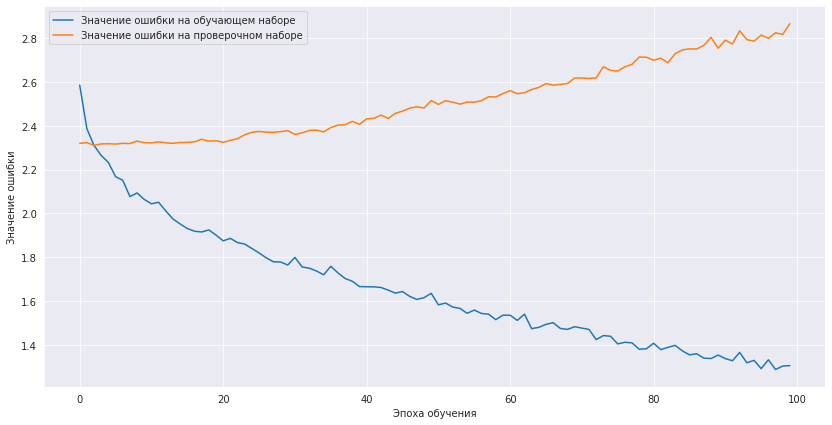

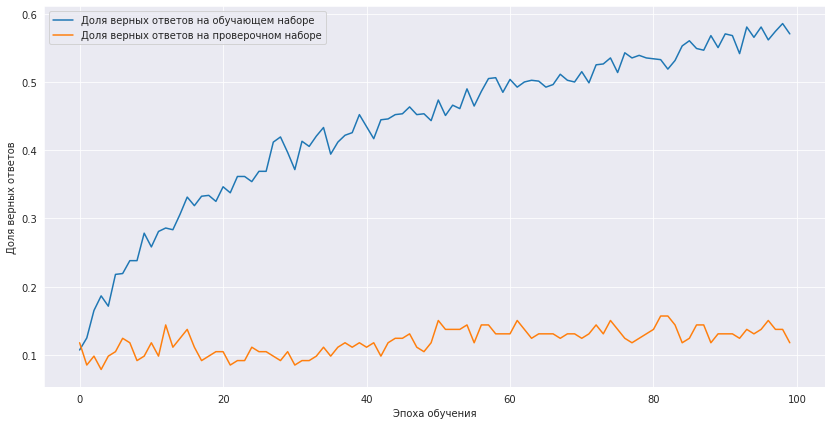

In [138]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [139]:
pred = recognizeMultiClass(modelSimpleRNN_3, xTest10Classes, "SimpleRNN") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  SimpleRNN

Аппендицит  распознано  15 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  18 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  13 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  8 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  0 % сеть считает, что это  Холицестит ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  14 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Холицестит  распознано  15 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  15 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!
Энтерит  распознано  6 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Язва  распознано  8 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  11 %



# **Иссл. №4**

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 100, 5)            500       
                                                                 
 spatial_dropout1d_23 (Spati  (None, 100, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_36 (Bat  (None, 100, 5)           20        
 chNormalization)                                                
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 20)                520       
                                                                 
 dropout_20 (Dropout)        (None, 20)                0         
                                                                 
 dense_41 (Dense)            (None, 10)              

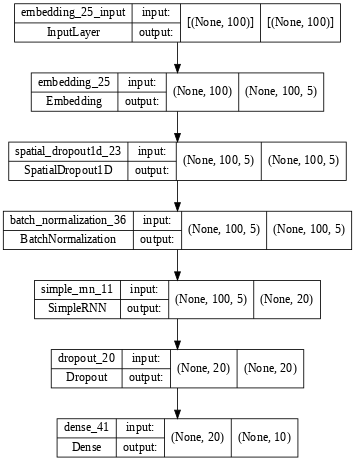

In [140]:
modelSimpleRNN_4 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelSimpleRNN_4.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelSimpleRNN_4.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelSimpleRNN_4.add(BatchNormalization()) # добавляем слой нормализации данных
modelSimpleRNN_4.add(SimpleRNN(20))
modelSimpleRNN_4.add(Dropout(0.4))
modelSimpleRNN_4.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelSimpleRNN_4.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelSimpleRNN_4.summary() # Выводим summary модели
print()
plot_model(modelSimpleRNN_4, dpi=60, show_shapes=True) # Выводим схему модели

In [141]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelSimpleRNN_4.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 2s 70ms/step - loss: 2.4705 - accuracy: 0.1020 - val_loss: 2.2905 - val_accuracy: 0.1176
Epoch 2/100
7/7 [==============================] - 0s 28ms/step - loss: 2.4535 - accuracy: 0.1096 - val_loss: 2.2901 - val_accuracy: 0.1242
Epoch 3/100
7/7 [==============================] - 0s 28ms/step - loss: 2.4024 - accuracy: 0.1146 - val_loss: 2.2942 - val_accuracy: 0.1111
Epoch 4/100
7/7 [==============================] - 0s 27ms/step - loss: 2.3846 - accuracy: 0.1196 - val_loss: 2.2951 - val_accuracy: 0.1307
Epoch 5/100
7/7 [==============================] - 0s 28ms/step - loss: 2.3593 - accuracy: 0.1184 - val_loss: 2.2973 - val_accuracy: 0.1242
Epoch 6/100
7/7 [==============================] - 0s 31ms/step - loss: 2.3495 - accuracy: 0.1322 - val_loss: 2.2985 - val_accuracy: 0.1176
Epoch 7/100
7/7 [==============================] - 0s 28ms/step - loss: 2.3347 - accuracy: 0.1348 - val_loss: 2.2995 - val_accuracy: 0.1438
Epoch 8/100
7/7 [===

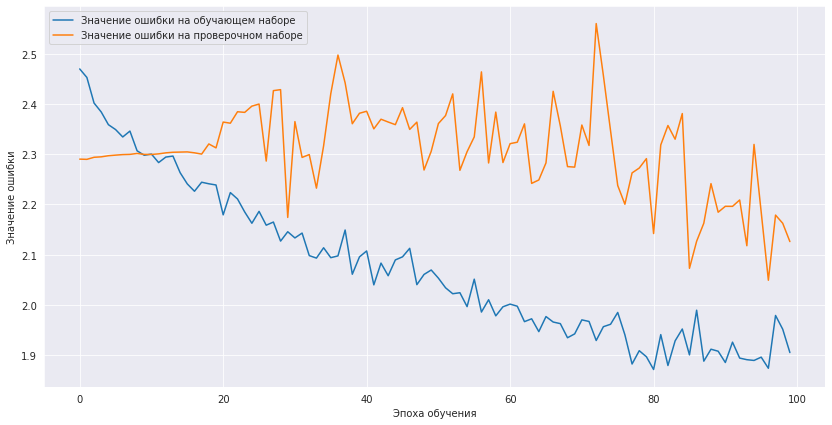

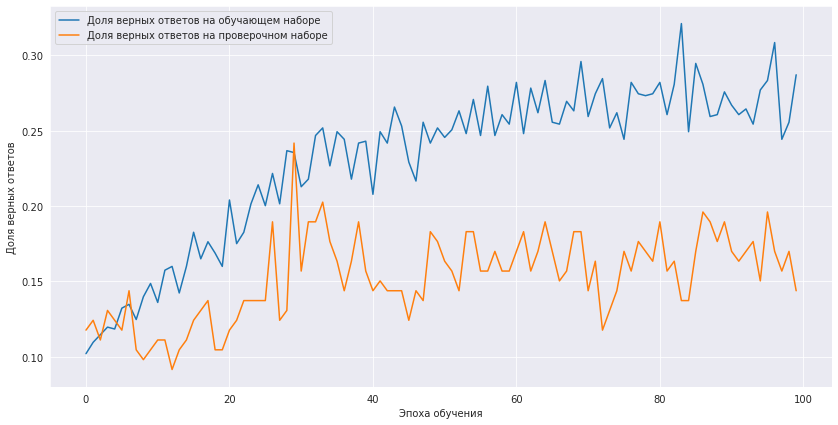

In [142]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [143]:
pred = recognizeMultiClass(modelSimpleRNN_4, xTest10Classes, "SimpleRNN") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  SimpleRNN

Аппендицит  распознано  23 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  6 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  12 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  14 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Холицестит  распознано  5 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  31 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Энтерит  распознано  18 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Язва  распознано  33 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  14 %



# GRU

# **Иссл. №5**

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 100, 5)            500       
                                                                 
 spatial_dropout1d_24 (Spati  (None, 100, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_37 (Bat  (None, 100, 5)           20        
 chNormalization)                                                
                                                                 
 gru_8 (GRU)                 (None, 4)                 132       
                                                                 
 dense_42 (Dense)            (None, 10)                50        
                                                                 
Total params: 702
Trainable params: 692
Non-trainable

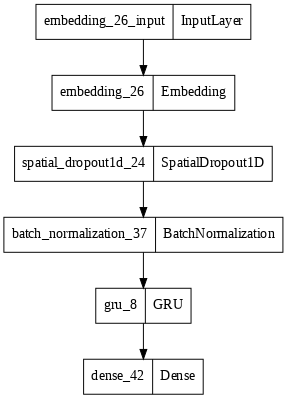

In [144]:
modelGRU_1 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelGRU_1.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelGRU_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelGRU_1.add(BatchNormalization()) # добавляем слой нормализации данных
modelGRU_1.add(GRU(4, dropout=0.2, recurrent_dropout=0.2, activation="relu"))
modelGRU_1.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelGRU_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelGRU_1.summary()
print()
plot_model(modelGRU_1, dpi=70)

In [145]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelGRU_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 5s 151ms/step - loss: 2.3020 - accuracy: 0.1159 - val_loss: 2.3012 - val_accuracy: 0.1046
Epoch 2/100
7/7 [==============================] - 1s 82ms/step - loss: 2.2910 - accuracy: 0.1146 - val_loss: 2.3012 - val_accuracy: 0.1046
Epoch 3/100
7/7 [==============================] - 1s 82ms/step - loss: 2.2902 - accuracy: 0.1259 - val_loss: 2.3014 - val_accuracy: 0.1046
Epoch 4/100
7/7 [==============================] - 1s 82ms/step - loss: 2.2811 - accuracy: 0.1159 - val_loss: 2.3013 - val_accuracy: 0.1046
Epoch 5/100
7/7 [==============================] - 1s 80ms/step - loss: 2.2845 - accuracy: 0.1222 - val_loss: 2.3014 - val_accuracy: 0.1046
Epoch 6/100
7/7 [==============================] - 1s 84ms/step - loss: 2.2705 - accuracy: 0.1285 - val_loss: 2.3012 - val_accuracy: 0.1046
Epoch 7/100
7/7 [==============================] - 1s 81ms/step - loss: 2.2771 - accuracy: 0.1272 - val_loss: 2.3011 - val_accuracy: 0.1046
Epoch 8/100
7/7 [==

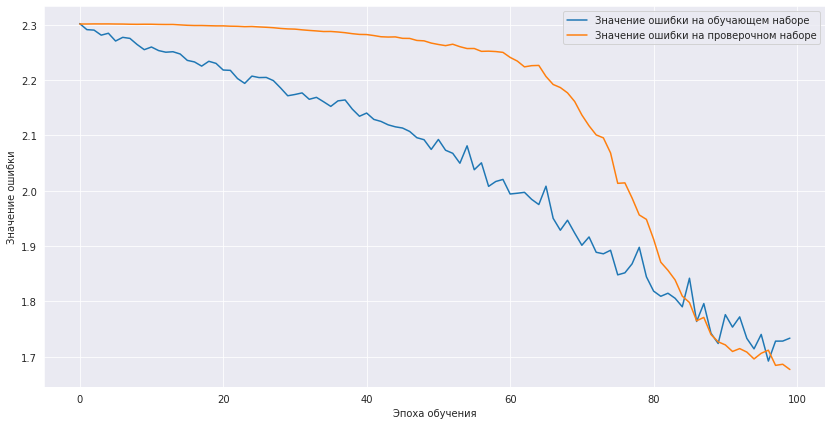

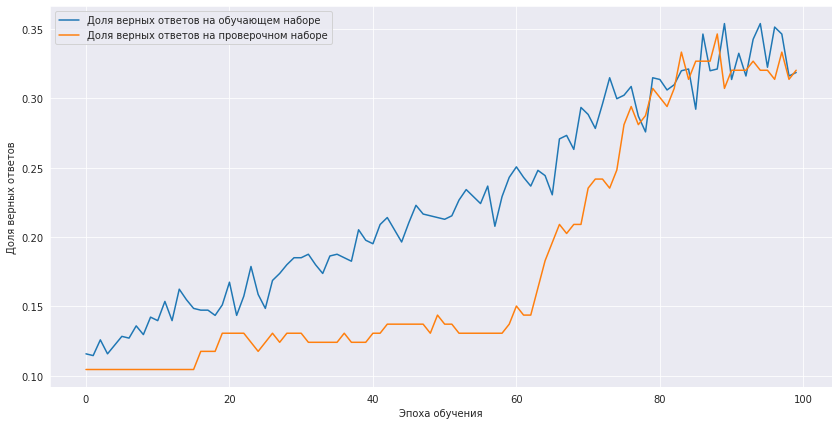

In [146]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [147]:
pred = recognizeMultiClass(modelGRU_1, xTest10Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  53 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  18 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  40 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  33 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  37 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Холицестит  распознано  5 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  68 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  18 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Язва  распознано  50 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  32 %



# **Иссл. №6**

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 100, 5)            500       
                                                                 
 spatial_dropout1d_25 (Spati  (None, 100, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_38 (Bat  (None, 100, 5)           20        
 chNormalization)                                                
                                                                 
 gru_9 (GRU)                 (None, 40)                5640      
                                                                 
 dense_43 (Dense)            (None, 10)                410       
                                                                 
Total params: 6,570
Trainable params: 6,560
Non-train

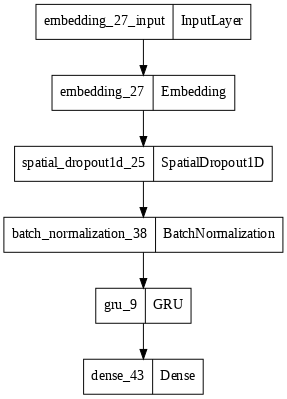

In [148]:
modelGRU_2 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelGRU_2.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelGRU_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelGRU_2.add(BatchNormalization()) # добавляем слой нормализации данных
modelGRU_2.add(GRU(40, dropout=0.4, recurrent_dropout=0.4, activation="relu"))
modelGRU_2.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelGRU_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelGRU_2.summary()
print()
plot_model(modelGRU_2, dpi=70)

In [149]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelGRU_2.fit(xTrain, 
                    yTrain, 
                    epochs=200,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/200
7/7 [==============================] - 5s 187ms/step - loss: 2.3033 - accuracy: 0.1058 - val_loss: 2.3031 - val_accuracy: 0.0784
Epoch 2/200
7/7 [==============================] - 1s 118ms/step - loss: 2.2990 - accuracy: 0.1134 - val_loss: 2.3032 - val_accuracy: 0.0784
Epoch 3/200
7/7 [==============================] - 1s 118ms/step - loss: 2.2905 - accuracy: 0.1348 - val_loss: 2.3030 - val_accuracy: 0.0784
Epoch 4/200
7/7 [==============================] - 1s 114ms/step - loss: 2.2898 - accuracy: 0.1196 - val_loss: 2.3027 - val_accuracy: 0.0784
Epoch 5/200
7/7 [==============================] - 1s 121ms/step - loss: 2.2801 - accuracy: 0.1322 - val_loss: 2.3030 - val_accuracy: 0.0784
Epoch 6/200
7/7 [==============================] - 1s 118ms/step - loss: 2.2804 - accuracy: 0.1461 - val_loss: 2.3032 - val_accuracy: 0.0784
Epoch 7/200
7/7 [==============================] - 1s 116ms/step - loss: 2.2814 - accuracy: 0.1259 - val_loss: 2.3027 - val_accuracy: 0.0784
Epoch 8/200
7

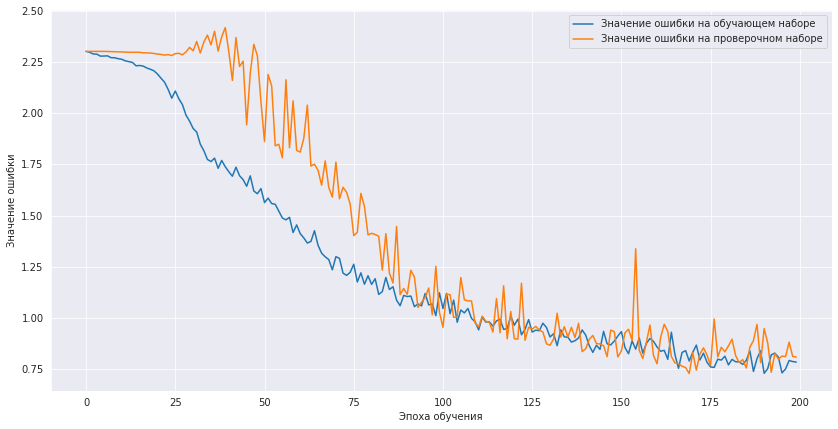

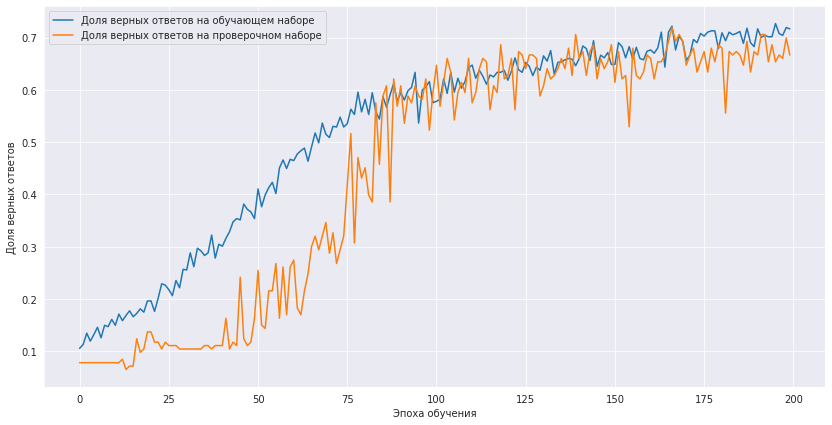

In [150]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


In [151]:
pred = recognizeMultiClass(modelGRU_2, xTest10Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  23 % сеть считает, что это  Энтерит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  62 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  93 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  50 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  81 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  78 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  75 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  78 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  68 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  33 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  66 %



# **Иссл. №7**

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 100, 5)            500       
                                                                 
 spatial_dropout1d_26 (Spati  (None, 100, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_39 (Bat  (None, 100, 5)           20        
 chNormalization)                                                
                                                                 
 gru_10 (GRU)                (None, 80)                20880     
                                                                 
 dense_44 (Dense)            (None, 10)                810       
                                                                 
Total params: 22,210
Trainable params: 22,200
Non-tra

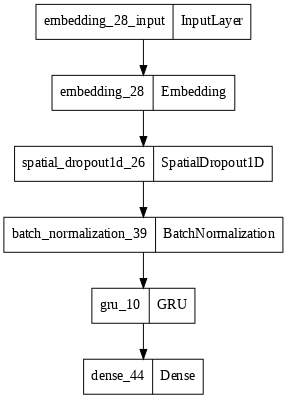

In [152]:
modelGRU_3 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelGRU_3.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelGRU_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelGRU_3.add(BatchNormalization()) # добавляем слой нормализации данных
modelGRU_3.add(GRU(80, dropout=0.2, recurrent_dropout=0.2, activation="relu"))
modelGRU_3.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelGRU_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelGRU_3.summary()
print()
plot_model(modelGRU_3, dpi=70)

In [153]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelGRU_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 5s 254ms/step - loss: 2.3082 - accuracy: 0.1058 - val_loss: 2.3025 - val_accuracy: 0.0784
Epoch 2/100
7/7 [==============================] - 1s 185ms/step - loss: 2.2958 - accuracy: 0.1222 - val_loss: 2.3026 - val_accuracy: 0.0784
Epoch 3/100
7/7 [==============================] - 1s 184ms/step - loss: 2.2933 - accuracy: 0.1184 - val_loss: 2.3026 - val_accuracy: 0.0784
Epoch 4/100
7/7 [==============================] - 1s 185ms/step - loss: 2.2901 - accuracy: 0.1297 - val_loss: 2.3019 - val_accuracy: 0.0784
Epoch 5/100
7/7 [==============================] - 1s 188ms/step - loss: 2.2807 - accuracy: 0.1247 - val_loss: 2.3015 - val_accuracy: 0.0784
Epoch 6/100
7/7 [==============================] - 1s 191ms/step - loss: 2.2768 - accuracy: 0.1385 - val_loss: 2.3008 - val_accuracy: 0.0915
Epoch 7/100
7/7 [==============================] - 1s 188ms/step - loss: 2.2744 - accuracy: 0.1360 - val_loss: 2.3006 - val_accuracy: 0.0915
Epoch 8/100
7

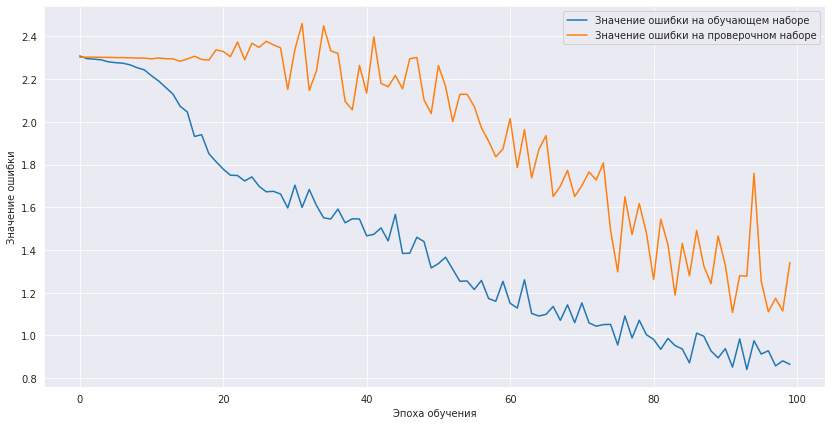

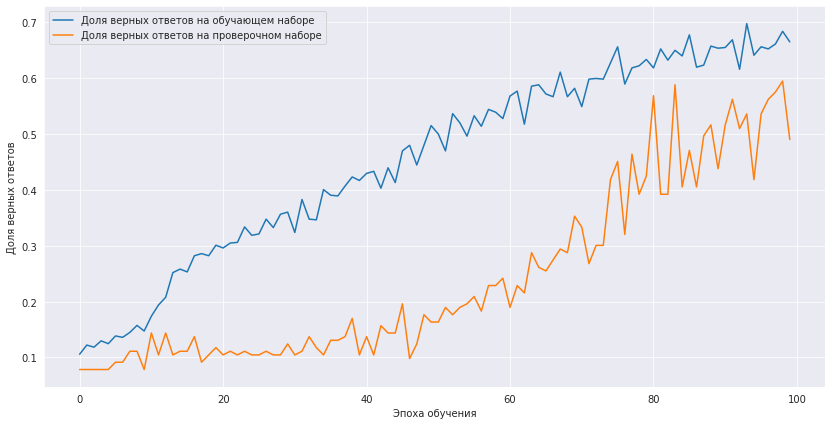

In [154]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [155]:
pred = recognizeMultiClass(modelGRU_3, xTest10Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  7 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  18 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  60 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  16 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  50 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  85 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  30 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  84 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  37 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Язва  распознано  100 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  49 %



# LSTM

# **Иссл. №8**

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 100, 5)            500       
                                                                 
 spatial_dropout1d_28 (Spati  (None, 100, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_41 (Bat  (None, 100, 5)           20        
 chNormalization)                                                
                                                                 
 lstm_1 (LSTM)               (None, 4)                 160       
                                                                 
 dense_46 (Dense)            (None, 10)                50        
                                                                 
Total params: 730
Trainable params: 720
Non-trainable

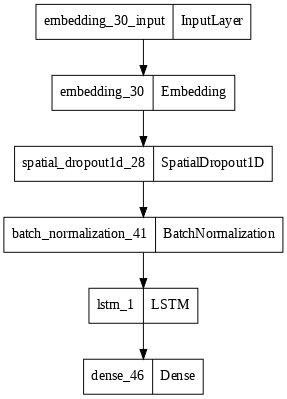

In [157]:
model_LSTM_1 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_1.add(Embedding(maxWordsCount, 5, input_length=xLen))

model_LSTM_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_1.add(LSTM(4))
model_LSTM_1.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_1.summary()
print()
plot_model(model_LSTM_1, dpi=70)

In [158]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 3s 128ms/step - loss: 2.3020 - accuracy: 0.1071 - val_loss: 2.3022 - val_accuracy: 0.1111
Epoch 2/100
7/7 [==============================] - 0s 40ms/step - loss: 2.2945 - accuracy: 0.1322 - val_loss: 2.3020 - val_accuracy: 0.0915
Epoch 3/100
7/7 [==============================] - 0s 42ms/step - loss: 2.2855 - accuracy: 0.1259 - val_loss: 2.3015 - val_accuracy: 0.0784
Epoch 4/100
7/7 [==============================] - 0s 42ms/step - loss: 2.2779 - accuracy: 0.1385 - val_loss: 2.3010 - val_accuracy: 0.0784
Epoch 5/100
7/7 [==============================] - 0s 40ms/step - loss: 2.2773 - accuracy: 0.1499 - val_loss: 2.3006 - val_accuracy: 0.0784
Epoch 6/100
7/7 [==============================] - 0s 43ms/step - loss: 2.2729 - accuracy: 0.1348 - val_loss: 2.3000 - val_accuracy: 0.0784
Epoch 7/100
7/7 [==============================] - 0s 42ms/step - loss: 2.2663 - accuracy: 0.1537 - val_loss: 2.2995 - val_accuracy: 0.0784
Epoch 8/100
7/7 [==

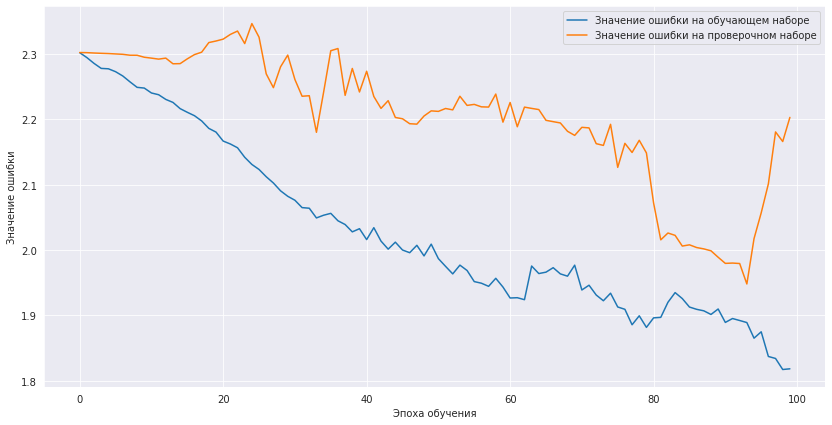

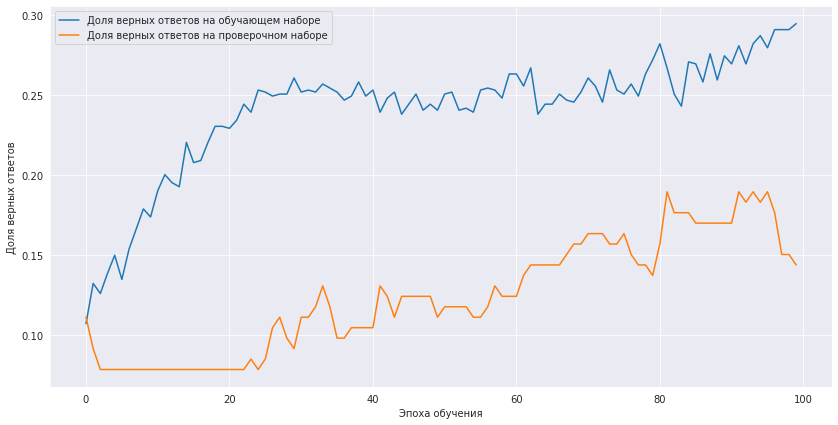

In [159]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [160]:
pred = recognizeMultiClass(model_LSTM_1, xTest10Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  23 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  0 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  18 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  0 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Холицестит  распознано  15 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  5 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Энтерит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Язва  распознано  100 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  14 %



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Иссл. №9**

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 100, 5)            500       
                                                                 
 spatial_dropout1d_29 (Spati  (None, 100, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_42 (Bat  (None, 100, 5)           20        
 chNormalization)                                                
                                                                 
 lstm_2 (LSTM)               (None, 20)                2080      
                                                                 
 dense_47 (Dense)            (None, 10)                210       
                                                                 
Total params: 2,810
Trainable params: 2,800
Non-train

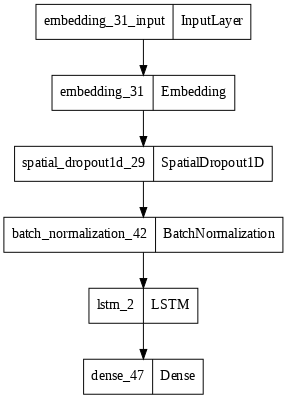

In [161]:
model_LSTM_2 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_2.add(Embedding(maxWordsCount, 5, input_length=xLen))

model_LSTM_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_2.add(LSTM(20))
model_LSTM_2.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_2.summary()
print()
plot_model(model_LSTM_2, dpi=70)

In [162]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 4s 137ms/step - loss: 2.3065 - accuracy: 0.0957 - val_loss: 2.3025 - val_accuracy: 0.0784
Epoch 2/100
7/7 [==============================] - 0s 58ms/step - loss: 2.2957 - accuracy: 0.1234 - val_loss: 2.3026 - val_accuracy: 0.0784
Epoch 3/100
7/7 [==============================] - 0s 53ms/step - loss: 2.2811 - accuracy: 0.1385 - val_loss: 2.3022 - val_accuracy: 0.0784
Epoch 4/100
7/7 [==============================] - 0s 53ms/step - loss: 2.2747 - accuracy: 0.1562 - val_loss: 2.3020 - val_accuracy: 0.0784
Epoch 5/100
7/7 [==============================] - 0s 51ms/step - loss: 2.2615 - accuracy: 0.1751 - val_loss: 2.3018 - val_accuracy: 0.1242
Epoch 6/100
7/7 [==============================] - 0s 53ms/step - loss: 2.2394 - accuracy: 0.1940 - val_loss: 2.3003 - val_accuracy: 0.1046
Epoch 7/100
7/7 [==============================] - 0s 51ms/step - loss: 2.2078 - accuracy: 0.2065 - val_loss: 2.2922 - val_accuracy: 0.1046
Epoch 8/100
7/7 [==

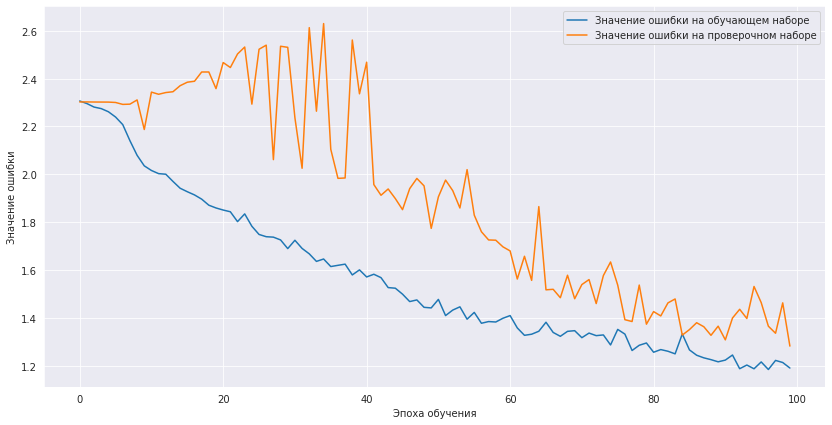

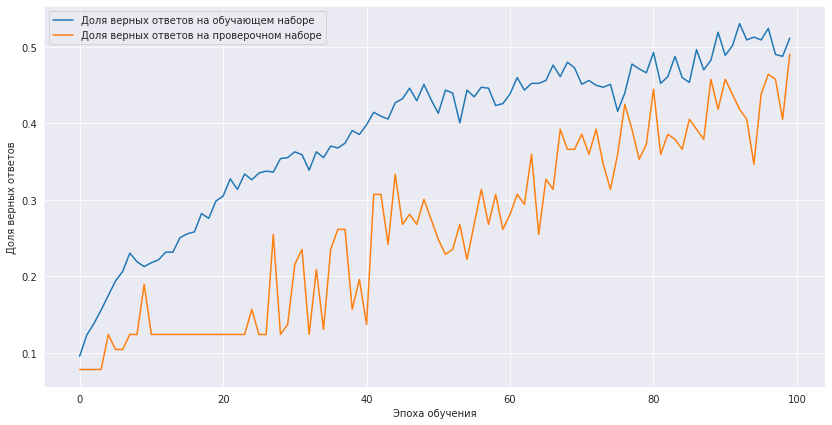

In [163]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [164]:
pred = recognizeMultiClass(model_LSTM_2, xTest10Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  23 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  6 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  100 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  43 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  64 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  60 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  36 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Энтерит  распознано  75 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  75 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  49 %



# **Иссл. №10**

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 100, 5)            500       
                                                                 
 spatial_dropout1d_31 (Spati  (None, 100, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_44 (Bat  (None, 100, 5)           20        
 chNormalization)                                                
                                                                 
 lstm_4 (LSTM)               (None, 100)               42400     
                                                                 
 dense_49 (Dense)            (None, 10)                1010      
                                                                 
Total params: 43,930
Trainable params: 43,920
Non-tra

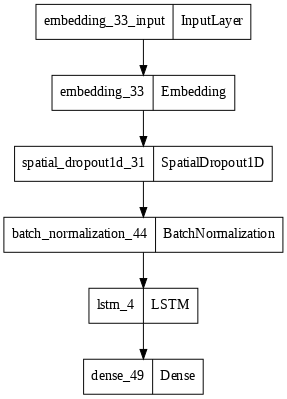

In [166]:
model_LSTM_3 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_3.add(Embedding(maxWordsCount, 5, input_length=xLen))

model_LSTM_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_3.add(LSTM(100))
model_LSTM_3.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_3.summary()
print()
plot_model(model_LSTM_3, dpi=70)

In [167]:
history = model_LSTM_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 4s 263ms/step - loss: 2.2988 - accuracy: 0.1196 - val_loss: 2.3019 - val_accuracy: 0.0784
Epoch 2/100
7/7 [==============================] - 1s 179ms/step - loss: 2.2689 - accuracy: 0.1839 - val_loss: 2.2993 - val_accuracy: 0.0784
Epoch 3/100
7/7 [==============================] - 1s 176ms/step - loss: 2.2051 - accuracy: 0.1990 - val_loss: 2.8829 - val_accuracy: 0.0784
Epoch 4/100
7/7 [==============================] - 1s 177ms/step - loss: 2.2537 - accuracy: 0.1889 - val_loss: 2.4216 - val_accuracy: 0.1046
Epoch 5/100
7/7 [==============================] - 1s 179ms/step - loss: 2.1575 - accuracy: 0.1864 - val_loss: 2.3774 - val_accuracy: 0.0784
Epoch 6/100
7/7 [==============================] - 1s 202ms/step - loss: 2.0908 - accuracy: 0.2166 - val_loss: 2.5168 - val_accuracy: 0.0784
Epoch 7/100
7/7 [==============================] - 1s 178ms/step - loss: 2.0320 - accuracy: 0.2292 - val_loss: 2.1387 - val_accuracy: 0.1503
Epoch 8/100
7

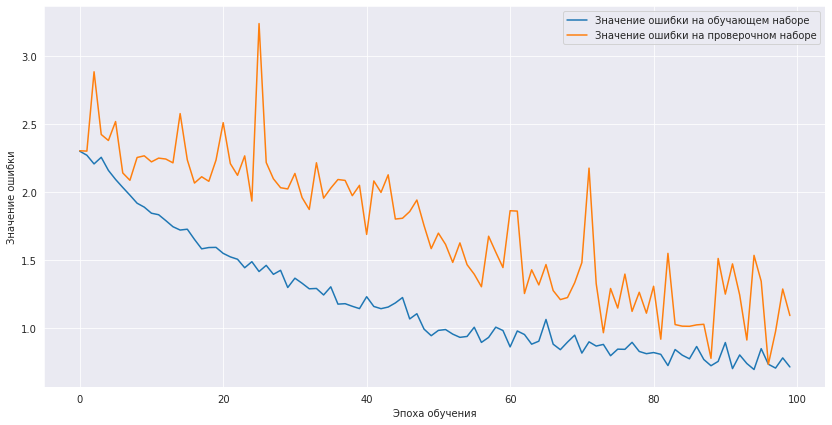

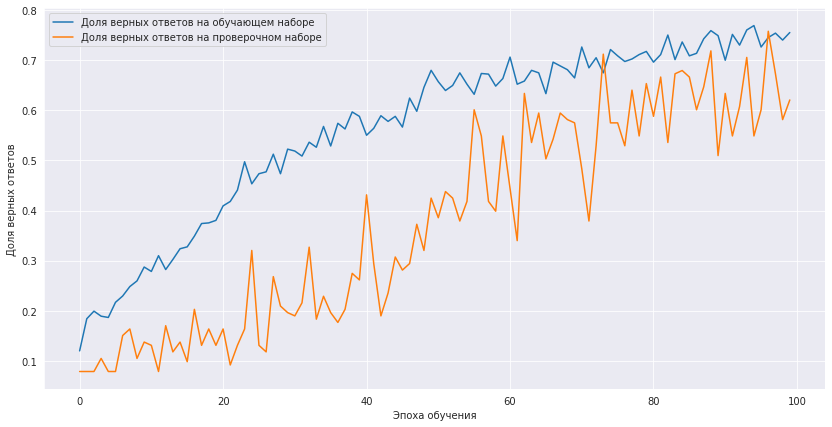

In [168]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [169]:
pred = recognizeMultiClass(model_LSTM_3, xTest10Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  30 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  37 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  93 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  16 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!
Колит  распознано  37 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  78 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  45 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  100 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  75 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  100 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  62 %



# **Иссл. №11**

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 100, 5)            500       
                                                                 
 spatial_dropout1d_32 (Spati  (None, 100, 5)           0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_45 (Bat  (None, 100, 5)           20        
 chNormalization)                                                
                                                                 
 lstm_5 (LSTM)               (None, 100, 4)            160       
                                                                 
 lstm_6 (LSTM)               (None, 4)                 144       
                                                                 
 dense_50 (Dense)            (None, 10)              

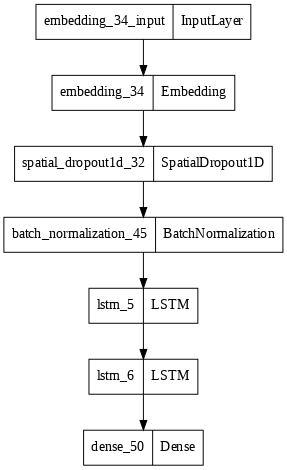

In [170]:
model_LSTM_4 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_4.add(Embedding(maxWordsCount, 5, input_length=xLen))

model_LSTM_4.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_4.add(BatchNormalization())  # добавляем слой нормализации данных
model_LSTM_4.add(LSTM(4, return_sequences=True))
model_LSTM_4.add(LSTM(4))
model_LSTM_4.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_4.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_4.summary()
print()
plot_model(model_LSTM_4, dpi=70)

In [171]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_4.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 5s 216ms/step - loss: 2.3031 - accuracy: 0.1083 - val_loss: 2.3045 - val_accuracy: 0.0784
Epoch 2/100
7/7 [==============================] - 1s 73ms/step - loss: 2.2884 - accuracy: 0.1348 - val_loss: 2.3050 - val_accuracy: 0.0784
Epoch 3/100
7/7 [==============================] - 1s 73ms/step - loss: 2.2813 - accuracy: 0.1486 - val_loss: 2.3056 - val_accuracy: 0.0784
Epoch 4/100
7/7 [==============================] - 1s 78ms/step - loss: 2.2770 - accuracy: 0.1549 - val_loss: 2.3041 - val_accuracy: 0.0784
Epoch 5/100
7/7 [==============================] - 1s 74ms/step - loss: 2.2670 - accuracy: 0.1914 - val_loss: 2.3043 - val_accuracy: 0.0784
Epoch 6/100
7/7 [==============================] - 1s 73ms/step - loss: 2.2557 - accuracy: 0.1788 - val_loss: 2.3017 - val_accuracy: 0.0784
Epoch 7/100
7/7 [==============================] - 1s 73ms/step - loss: 2.2496 - accuracy: 0.1776 - val_loss: 2.3027 - val_accuracy: 0.0784
Epoch 8/100
7/7 [==

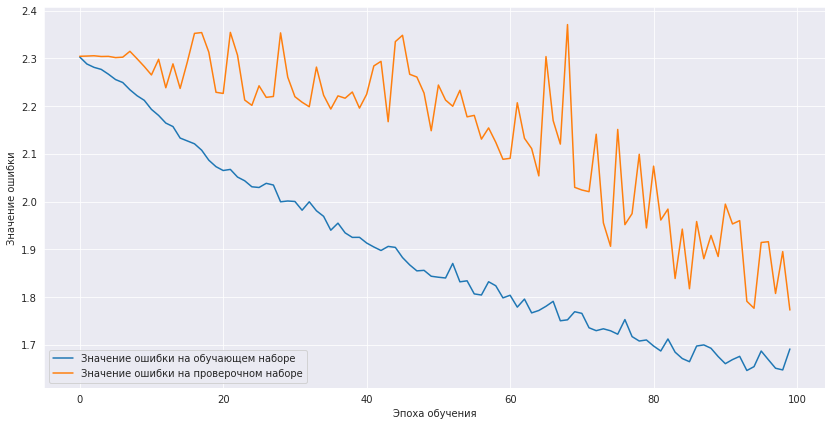

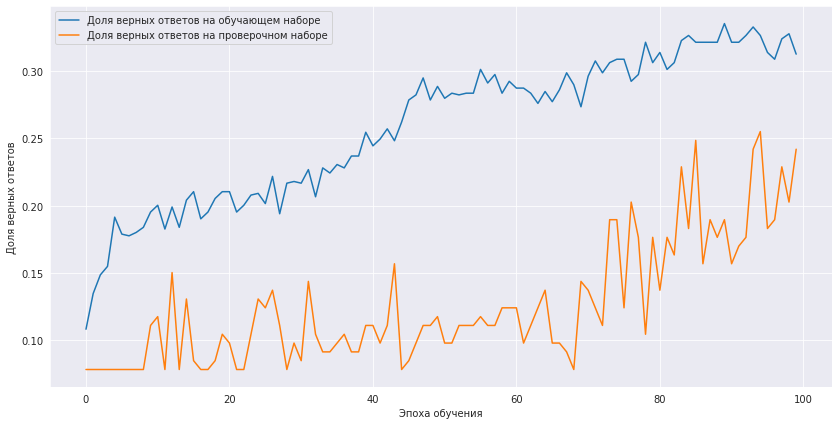

In [172]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [173]:
pred = recognizeMultiClass(model_LSTM_4, xTest10Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  61 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  0 % сеть считает, что это  Холицестит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  0 % сеть считает, что это  Холицестит ,  распознано НЕ ВЕРНО!
Холицестит  распознано  85 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Энтерит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Язва  распознано  100 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  24 %



# **Иссл. №12**

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 100, 200)          20000     
                                                                 
 spatial_dropout1d_33 (Spati  (None, 100, 200)         0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_46 (Bat  (None, 100, 200)         800       
 chNormalization)                                                
                                                                 
 lstm_7 (LSTM)               (None, 100, 4)            3280      
                                                                 
 lstm_8 (LSTM)               (None, 4)                 144       
                                                                 
 dense_51 (Dense)            (None, 10)              

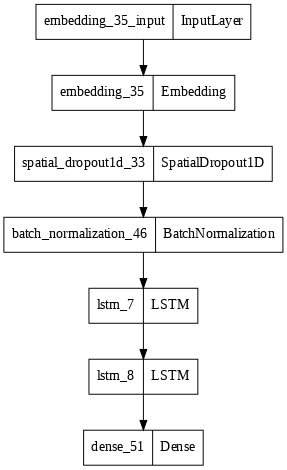

In [174]:
model_LSTM_5 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_5.add(Embedding(maxWordsCount, 200, input_length=xLen))

model_LSTM_5.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_5.add(BatchNormalization())  # добавляем слой нормализации данных
model_LSTM_5.add(LSTM(4, return_sequences=True))
model_LSTM_5.add(LSTM(4))
model_LSTM_5.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_5.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_5.summary()
print()
plot_model(model_LSTM_5, dpi=70)

In [175]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_5.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 6s 268ms/step - loss: 2.2943 - accuracy: 0.1297 - val_loss: 2.3013 - val_accuracy: 0.1111
Epoch 2/100
7/7 [==============================] - 1s 124ms/step - loss: 2.2633 - accuracy: 0.1751 - val_loss: 2.2999 - val_accuracy: 0.0850
Epoch 3/100
7/7 [==============================] - 1s 125ms/step - loss: 2.2496 - accuracy: 0.1965 - val_loss: 2.2992 - val_accuracy: 0.1242
Epoch 4/100
7/7 [==============================] - 1s 123ms/step - loss: 2.2341 - accuracy: 0.2204 - val_loss: 2.2981 - val_accuracy: 0.1242
Epoch 5/100
7/7 [==============================] - 1s 121ms/step - loss: 2.2199 - accuracy: 0.2431 - val_loss: 2.2969 - val_accuracy: 0.1307
Epoch 6/100
7/7 [==============================] - 1s 123ms/step - loss: 2.2098 - accuracy: 0.2456 - val_loss: 2.2956 - val_accuracy: 0.1373
Epoch 7/100
7/7 [==============================] - 1s 123ms/step - loss: 2.1961 - accuracy: 0.2481 - val_loss: 2.2953 - val_accuracy: 0.1373
Epoch 8/100
7

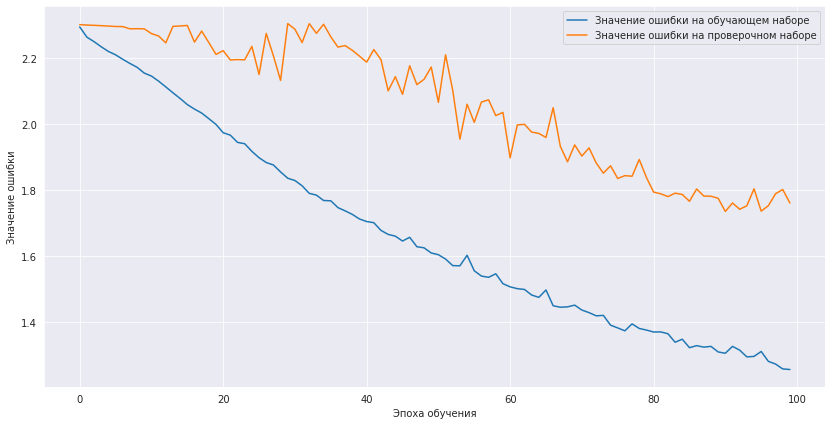

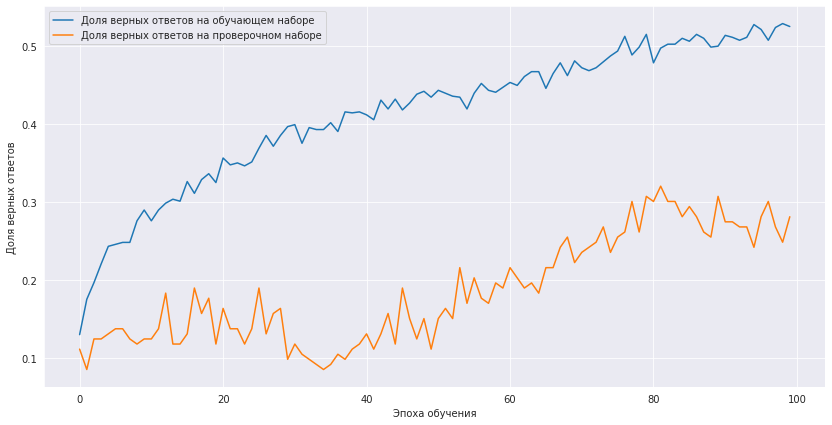

In [176]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [177]:
pred = recognizeMultiClass(model_LSTM_5, xTest10Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  53 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  12 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  0 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  16 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  37 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  35 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  0 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  15 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Энтерит  распознано  62 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  66 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  28 %



# **Иссл. №13**

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 100, 50)           5000      
                                                                 
 spatial_dropout1d_35 (Spati  (None, 100, 50)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_51 (Bat  (None, 100, 50)          200       
 chNormalization)                                                
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 16)          3776      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 16)          1600      
 nal)                                                

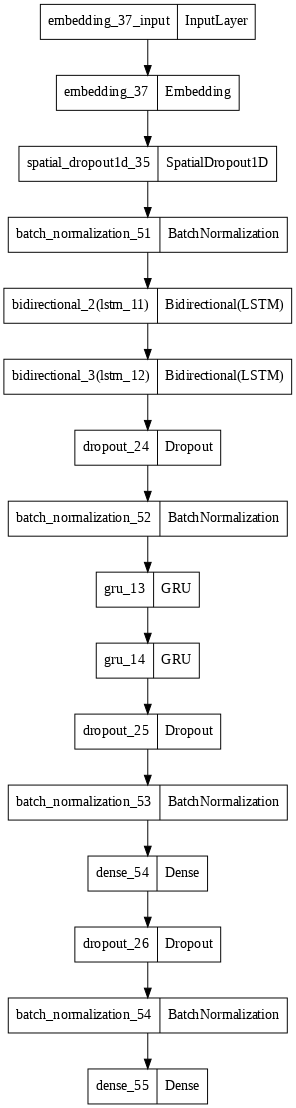

In [180]:
model_LSTM_6 = Sequential() # создаём последовательную модель нейросети
model_LSTM_6 = Sequential() #создаём последовательную модель нейросети

#преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_6.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_LSTM_6.add(SpatialDropout1D(0.4)) #добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_6.add(BatchNormalization()) #добавляем слой нормализации данных
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_6.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_6.add(BatchNormalization()) #добавляем слой нормализации данных
model_LSTM_6.add(GRU(16, return_sequences=True, reset_after=True)) #добавляем слой GRU, совместимый с Cuda при поддержке GPU
model_LSTM_6.add(GRU(16, reset_after=True)) #добавляем слой GRU, совместимый с Cuda при поддержке GPU
model_LSTM_6.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_6.add(BatchNormalization()) #добавляем слой нормализации данных
model_LSTM_6.add(Dense(200, activation='relu')) #добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LSTM_6.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_6.add(BatchNormalization()) #добавляем слой нормализации данных
model_LSTM_6.add(Dense(10, activation='softmax')) #добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое


# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_6.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_6.summary()
print()
plot_model(model_LSTM_6, dpi=70)

In [181]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_6.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 16s 583ms/step - loss: 2.8947 - accuracy: 0.0957 - val_loss: 2.3035 - val_accuracy: 0.0784
Epoch 2/100
7/7 [==============================] - 2s 220ms/step - loss: 2.7552 - accuracy: 0.1159 - val_loss: 2.3046 - val_accuracy: 0.0784
Epoch 3/100
7/7 [==============================] - 2s 221ms/step - loss: 2.6698 - accuracy: 0.1171 - val_loss: 2.3065 - val_accuracy: 0.0784
Epoch 4/100
7/7 [==============================] - 2s 224ms/step - loss: 2.6309 - accuracy: 0.1373 - val_loss: 2.3074 - val_accuracy: 0.0784
Epoch 5/100
7/7 [==============================] - 2s 220ms/step - loss: 2.6311 - accuracy: 0.1096 - val_loss: 2.3076 - val_accuracy: 0.0784
Epoch 6/100
7/7 [==============================] - 2s 220ms/step - loss: 2.5747 - accuracy: 0.1096 - val_loss: 2.3092 - val_accuracy: 0.0784
Epoch 7/100
7/7 [==============================] - 2s 222ms/step - loss: 2.5742 - accuracy: 0.1209 - val_loss: 2.3081 - val_accuracy: 0.0784
Epoch 8/100


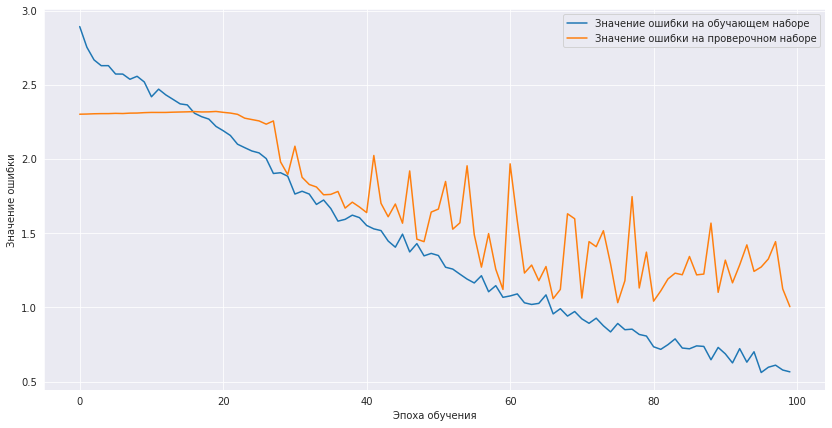

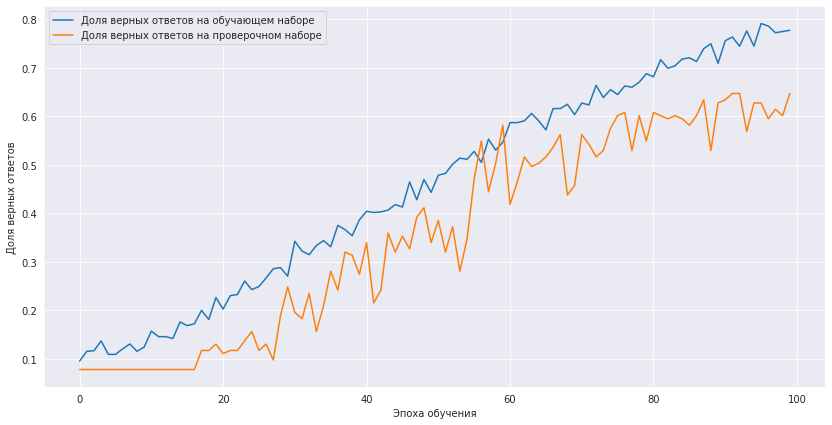

In [182]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [183]:
pred = recognizeMultiClass(model_LSTM_6, xTest10Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  30 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  56 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  86 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  50 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  31 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  28 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  75 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  84 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  100 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  91 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  64 %



# **Иссл. №14**

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 100, 50)           5000      
                                                                 
 spatial_dropout1d_36 (Spati  (None, 100, 50)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_55 (Bat  (None, 100, 50)          200       
 chNormalization)                                                
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 16)          3776      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 16)               1600      
 nal)                                                

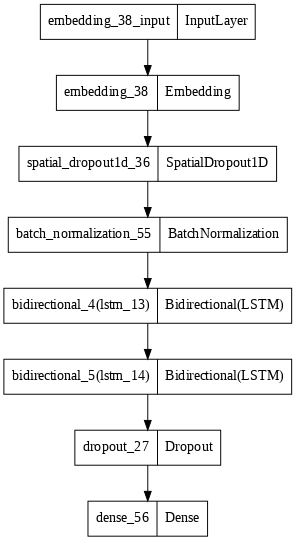

In [184]:
model_LSTM_7 = Sequential() #создаём последовательную модель нейросети

#преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_7.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_LSTM_7.add(SpatialDropout1D(0.4)) #добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_7.add(BatchNormalization()) #добавляем слой нормализации данных
model_LSTM_7.add(Bidirectional(LSTM(8, return_sequences=True))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_7.add(Bidirectional(LSTM(8))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_7.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_7.add(Dense(10, activation='softmax')) #добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое


# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_7.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_7.summary()
print()
plot_model(model_LSTM_7, dpi=70)

In [185]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_7.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 9s 387ms/step - loss: 2.3052 - accuracy: 0.1184 - val_loss: 2.2999 - val_accuracy: 0.1176
Epoch 2/100
7/7 [==============================] - 1s 136ms/step - loss: 2.2804 - accuracy: 0.1398 - val_loss: 2.2976 - val_accuracy: 0.1046
Epoch 3/100
7/7 [==============================] - 1s 138ms/step - loss: 2.2634 - accuracy: 0.1574 - val_loss: 2.2952 - val_accuracy: 0.1046
Epoch 4/100
7/7 [==============================] - 1s 136ms/step - loss: 2.2406 - accuracy: 0.1814 - val_loss: 2.2930 - val_accuracy: 0.1046
Epoch 5/100
7/7 [==============================] - 1s 135ms/step - loss: 2.2274 - accuracy: 0.1851 - val_loss: 2.2909 - val_accuracy: 0.1242
Epoch 6/100
7/7 [==============================] - 1s 135ms/step - loss: 2.2076 - accuracy: 0.2078 - val_loss: 2.2867 - val_accuracy: 0.1373
Epoch 7/100
7/7 [==============================] - 1s 133ms/step - loss: 2.1867 - accuracy: 0.2456 - val_loss: 2.2823 - val_accuracy: 0.1111
Epoch 8/100
7

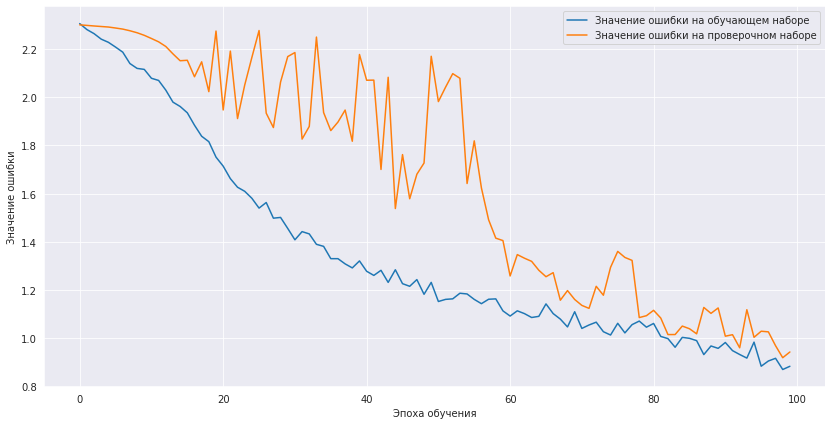

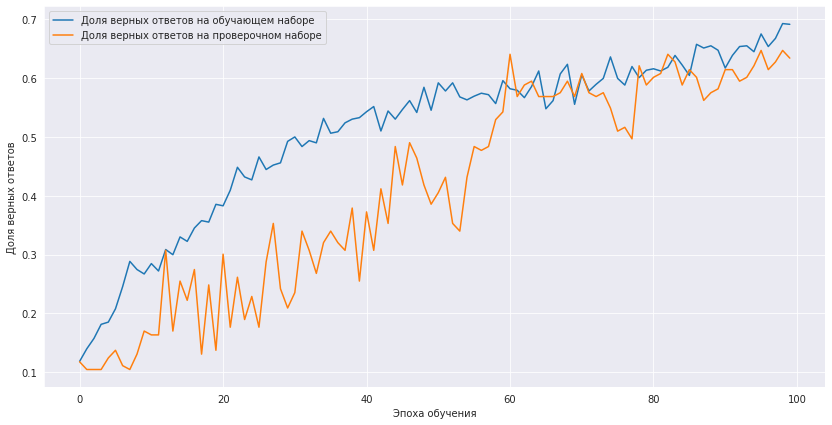

In [186]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [187]:
pred = recognizeMultiClass(model_LSTM_7, xTest10Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  23 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  56 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  100 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  8 % сеть считает, что это  Гастрит ,  распознано НЕ ВЕРНО!
Колит  распознано  56 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  42 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  65 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  73 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  93 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  100 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  63 %



# **Иссл. №15**

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 100, 10)           1000      
                                                                 
 spatial_dropout1d_38 (Spati  (None, 100, 10)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_59 (Bat  (None, 100, 10)          40        
 chNormalization)                                                
                                                                 
 lstm_16 (LSTM)              (None, 4)                 240       
                                                                 
 dropout_30 (Dropout)        (None, 4)                 0         
                                                                 
 batch_normalization_60 (Bat  (None, 4)              

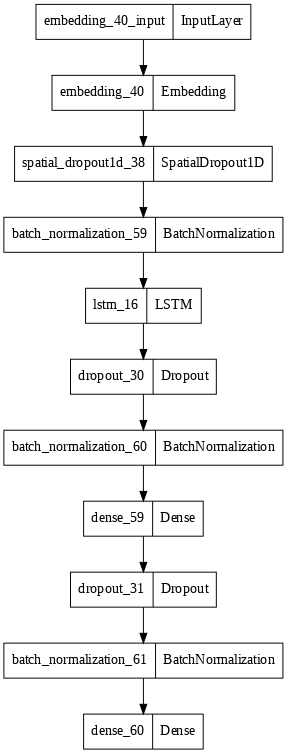

In [190]:
model_LSTM_8 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_8.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LSTM_8.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_8.add(BatchNormalization())  # добавляем слой нормализации данных
model_LSTM_8.add(LSTM(4)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_8.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_8.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_8.add(Dense(100, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LSTM_8.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_8.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_8.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_8.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_8.summary()
print()
plot_model(model_LSTM_8, dpi=70)

In [191]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_8.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 7s 305ms/step - loss: 2.9855 - accuracy: 0.0806 - val_loss: 2.3017 - val_accuracy: 0.1046
Epoch 2/100
7/7 [==============================] - 1s 83ms/step - loss: 2.8129 - accuracy: 0.0894 - val_loss: 2.3021 - val_accuracy: 0.1176
Epoch 3/100
7/7 [==============================] - 1s 90ms/step - loss: 2.7834 - accuracy: 0.0945 - val_loss: 2.3023 - val_accuracy: 0.0915
Epoch 4/100
7/7 [==============================] - 1s 96ms/step - loss: 2.7413 - accuracy: 0.0894 - val_loss: 2.3030 - val_accuracy: 0.0784
Epoch 5/100
7/7 [==============================] - 1s 82ms/step - loss: 2.7393 - accuracy: 0.0945 - val_loss: 2.3035 - val_accuracy: 0.0784
Epoch 6/100
7/7 [==============================] - 1s 88ms/step - loss: 2.6532 - accuracy: 0.1121 - val_loss: 2.3036 - val_accuracy: 0.0784
Epoch 7/100
7/7 [==============================] - 1s 88ms/step - loss: 2.6786 - accuracy: 0.1071 - val_loss: 2.3031 - val_accuracy: 0.0784
Epoch 8/100
7/7 [==

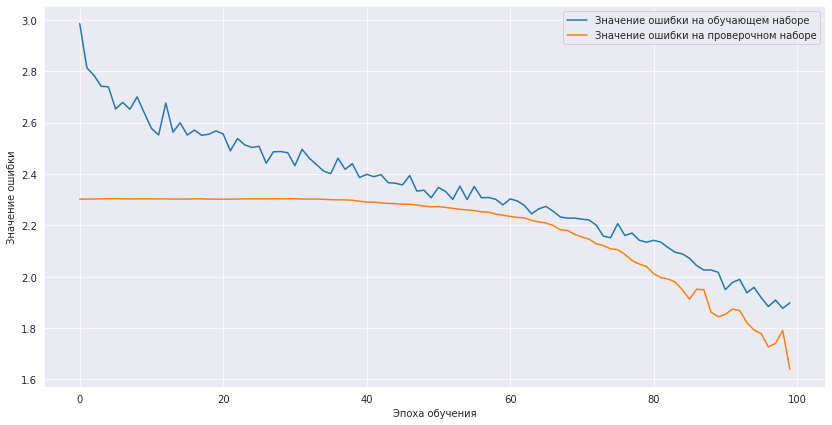

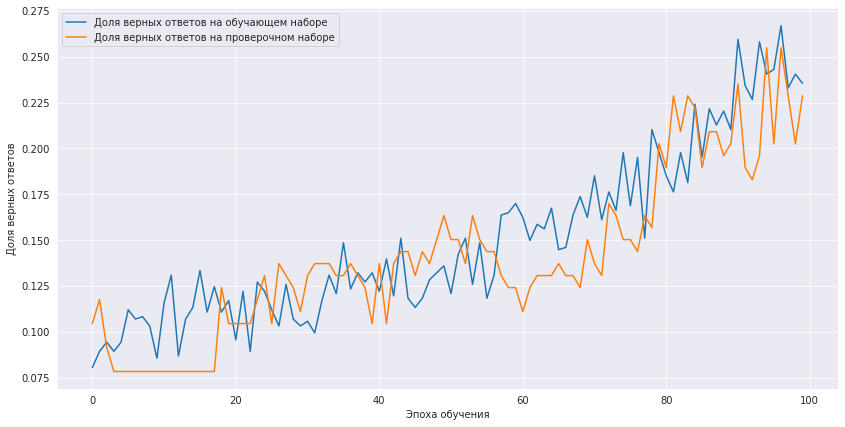

In [192]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [193]:
pred = recognizeMultiClass(model_LSTM_8, xTest10Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  46 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  33 % сеть считает, что это  Холицестит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  6 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  7 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Холицестит  распознано  35 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  5 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Энтерит  распознано  18 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Язва  распознано  91 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  22 %



# **Иссл. №16**

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 100, 10)           1000      
                                                                 
 spatial_dropout1d_39 (Spati  (None, 100, 10)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_62 (Bat  (None, 100, 10)          40        
 chNormalization)                                                
                                                                 
 lstm_17 (LSTM)              (None, 100, 4)            240       
                                                                 
 dropout_32 (Dropout)        (None, 100, 4)            0         
                                                                 
 batch_normalization_63 (Bat  (None, 100, 4)         

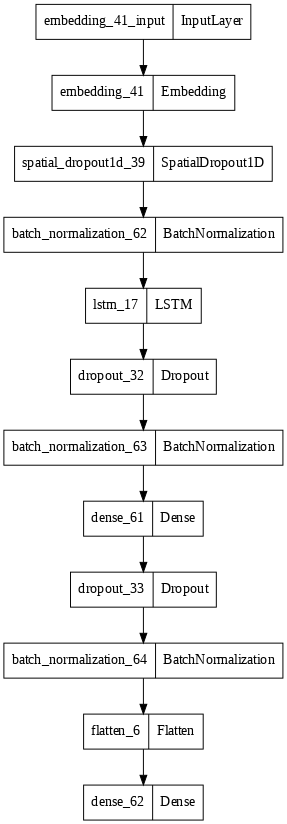

In [194]:
model_LSTM_9 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_9.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LSTM_9.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_9.add(BatchNormalization())  # добавляем слой нормализации данных
model_LSTM_9.add(LSTM(4, return_sequences=True)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_9.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_9.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_9.add(Dense(100, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LSTM_9.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_9.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_9.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_LSTM_9.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_9.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_9.summary()
print()
plot_model(model_LSTM_9, dpi=70)

In [195]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_9.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 5s 180ms/step - loss: 3.2200 - accuracy: 0.0970 - val_loss: 2.3008 - val_accuracy: 0.1242
Epoch 2/100
7/7 [==============================] - 1s 84ms/step - loss: 3.1578 - accuracy: 0.1272 - val_loss: 2.3014 - val_accuracy: 0.1307
Epoch 3/100
7/7 [==============================] - 1s 82ms/step - loss: 2.9952 - accuracy: 0.1171 - val_loss: 2.3027 - val_accuracy: 0.0850
Epoch 4/100
7/7 [==============================] - 1s 86ms/step - loss: 2.9817 - accuracy: 0.1297 - val_loss: 2.3038 - val_accuracy: 0.1242
Epoch 5/100
7/7 [==============================] - 1s 85ms/step - loss: 2.8313 - accuracy: 0.1486 - val_loss: 2.3093 - val_accuracy: 0.0850
Epoch 6/100
7/7 [==============================] - 1s 82ms/step - loss: 2.8181 - accuracy: 0.1524 - val_loss: 2.3120 - val_accuracy: 0.1307
Epoch 7/100
7/7 [==============================] - 1s 84ms/step - loss: 2.6062 - accuracy: 0.1940 - val_loss: 2.3142 - val_accuracy: 0.1307
Epoch 8/100
7/7 [==

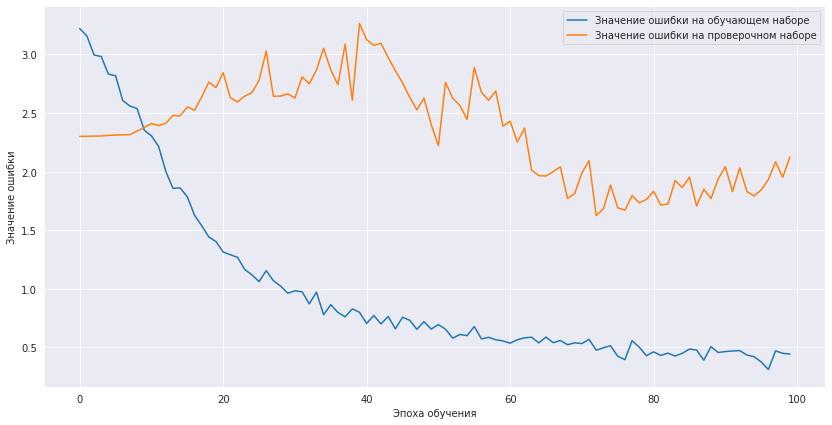

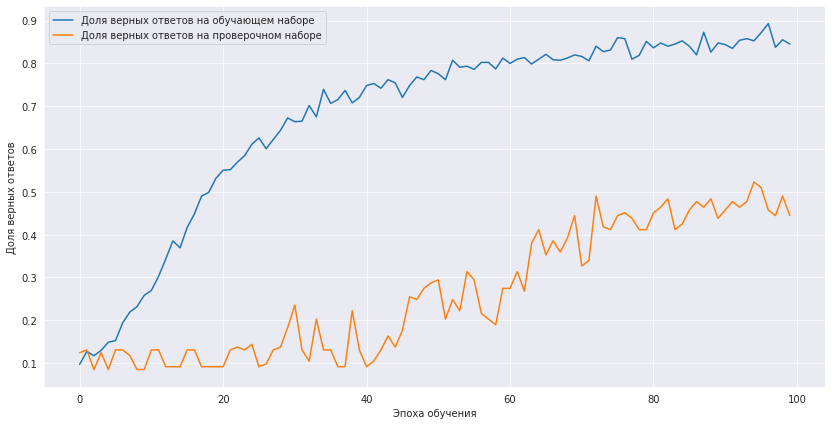

In [196]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [197]:
pred = recognizeMultiClass(model_LSTM_9, xTest10Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

Аппендицит  распознано  23 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  6 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  26 % сеть считает, что это  Холицестит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  0 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Колит  распознано  31 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  42 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  95 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  68 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  50 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  75 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  44 %



# Conv1D

# **Иссл. №17**

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 100, 10)           1000      
                                                                 
 spatial_dropout1d_40 (Spati  (None, 100, 10)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_65 (Bat  (None, 100, 10)          40        
 chNormalization)                                                
                                                                 
 conv1d (Conv1D)             (None, 100, 20)           1020      
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 20)            2020      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 20)         

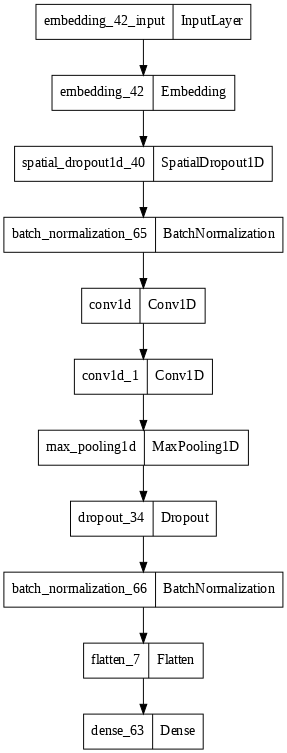

In [198]:
model_Conv_1 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Conv_1.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_Conv_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Conv_1.add(BatchNormalization())  # добавляем слой нормализации данных
model_Conv_1.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_1.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_1.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Conv_1.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Conv_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Conv_1.summary()
print()
plot_model(model_Conv_1, dpi=70)

In [199]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Conv_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 3s 91ms/step - loss: 3.0163 - accuracy: 0.0919 - val_loss: 2.3003 - val_accuracy: 0.1307
Epoch 2/100
7/7 [==============================] - 0s 31ms/step - loss: 2.6940 - accuracy: 0.1348 - val_loss: 2.3001 - val_accuracy: 0.0915
Epoch 3/100
7/7 [==============================] - 0s 32ms/step - loss: 2.5039 - accuracy: 0.1788 - val_loss: 2.3002 - val_accuracy: 0.0980
Epoch 4/100
7/7 [==============================] - 0s 31ms/step - loss: 2.2999 - accuracy: 0.2254 - val_loss: 2.3016 - val_accuracy: 0.0719
Epoch 5/100
7/7 [==============================] - 0s 30ms/step - loss: 2.1982 - accuracy: 0.2179 - val_loss: 2.3048 - val_accuracy: 0.0719
Epoch 6/100
7/7 [==============================] - 0s 29ms/step - loss: 2.0485 - accuracy: 0.3010 - val_loss: 2.3074 - val_accuracy: 0.0915
Epoch 7/100
7/7 [==============================] - 0s 29ms/step - loss: 1.9376 - accuracy: 0.3275 - val_loss: 2.3117 - val_accuracy: 0.0915
Epoch 8/100
7/7 [===

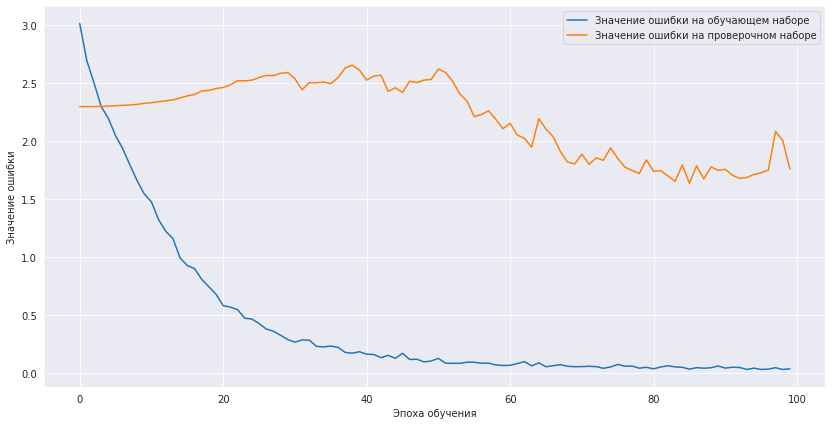

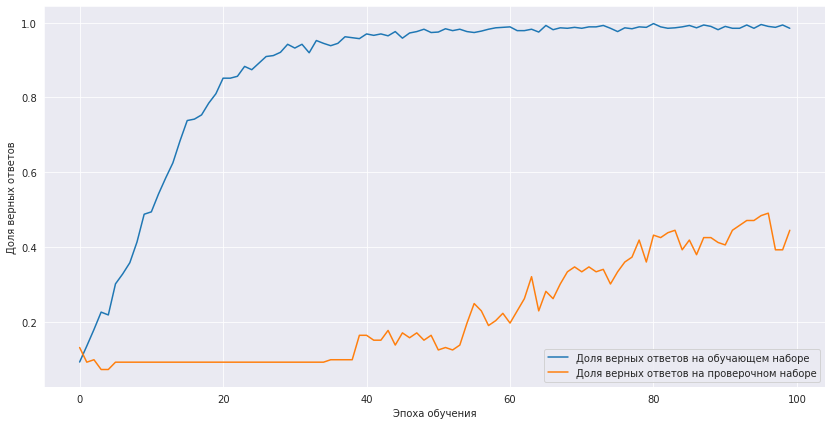

In [200]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [201]:
pred = recognizeMultiClass(model_Conv_1, xTest10Classes, "Embedding + Conv") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv

Аппендицит  распознано  46 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  31 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  80 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  58 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  18 % сеть считает, что это  Энтерит ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  0 % сеть считает, что это  Эзофагит ,  распознано НЕ ВЕРНО!
Холицестит  распознано  45 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  94 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  18 % сеть считает, что это  Колит ,  распознано НЕ ВЕРНО!
Язва  распознано  41 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  44 %



# **Иссл. №18**

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 100, 50)           5000      
                                                                 
 spatial_dropout1d_41 (Spati  (None, 100, 50)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_67 (Bat  (None, 100, 50)          200       
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 20)           5020      
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 20)           2020      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 20)         

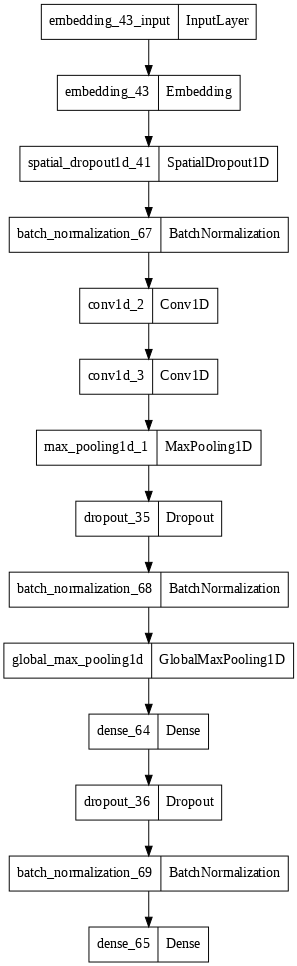

In [202]:
model_Conv_2 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Conv_2.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_Conv_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Conv_2.add(BatchNormalization())  # добавляем слой нормализации данных
model_Conv_2.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_2.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_2.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_2.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_2.add(GlobalMaxPooling1D()) # добавляем слой подвыборки/пулинга с функцией максимума(по всей длине входящей последовательности)
model_Conv_2.add(Dense(20, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_Conv_2.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_2.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Conv_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model_Conv_2.summary()
print()
plot_model(model_Conv_2, dpi=70)

In [203]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Conv_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 3s 91ms/step - loss: 2.5411 - accuracy: 0.1171 - val_loss: 2.2995 - val_accuracy: 0.1046
Epoch 2/100
7/7 [==============================] - 0s 55ms/step - loss: 2.2348 - accuracy: 0.1725 - val_loss: 2.3069 - val_accuracy: 0.1046
Epoch 3/100
7/7 [==============================] - 0s 56ms/step - loss: 2.1306 - accuracy: 0.2292 - val_loss: 2.3163 - val_accuracy: 0.1046
Epoch 4/100
7/7 [==============================] - 0s 55ms/step - loss: 2.0408 - accuracy: 0.2645 - val_loss: 2.3252 - val_accuracy: 0.1046
Epoch 5/100
7/7 [==============================] - 0s 56ms/step - loss: 1.9162 - accuracy: 0.3086 - val_loss: 2.3307 - val_accuracy: 0.1046
Epoch 6/100
7/7 [==============================] - 0s 56ms/step - loss: 1.8209 - accuracy: 0.3501 - val_loss: 2.3363 - val_accuracy: 0.1046
Epoch 7/100
7/7 [==============================] - 0s 56ms/step - loss: 1.7459 - accuracy: 0.4018 - val_loss: 2.3415 - val_accuracy: 0.1046
Epoch 8/100
7/7 [===

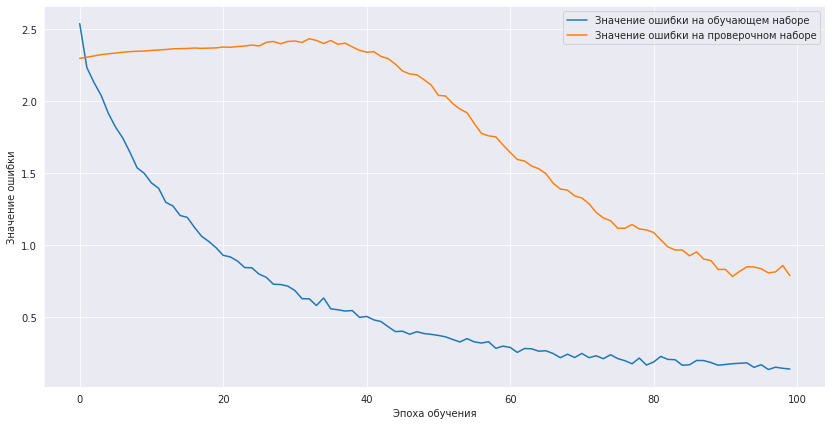

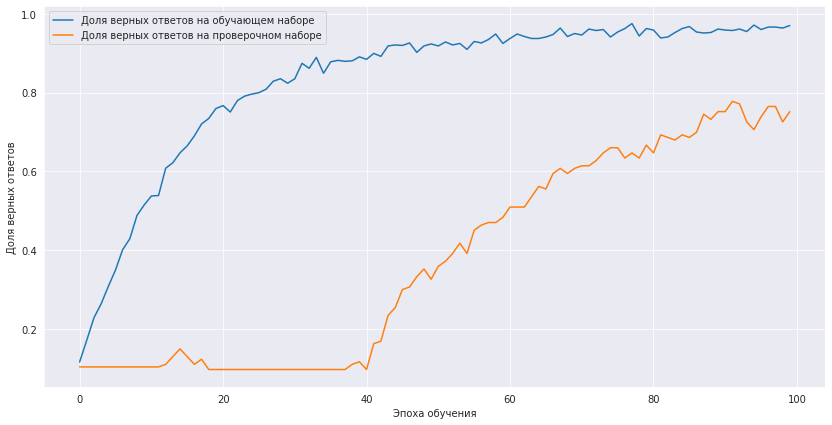

In [204]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [205]:
pred = recognizeMultiClass(model_Conv_2, xTest10Classes, "Embedding + Conv") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv

Аппендицит  распознано  69 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  31 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  66 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  58 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  81 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  71 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  95 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  89 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  81 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  100 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  75 %



# **Иссл. №19**

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 100, 10)           1000      
                                                                 
 spatial_dropout1d_42 (Spati  (None, 100, 10)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_70 (Bat  (None, 100, 10)          40        
 chNormalization)                                                
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 20)            1020      
                                                                 
 conv1d_5 (Conv1D)           (None, 92, 20)            2020      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 46, 20)         

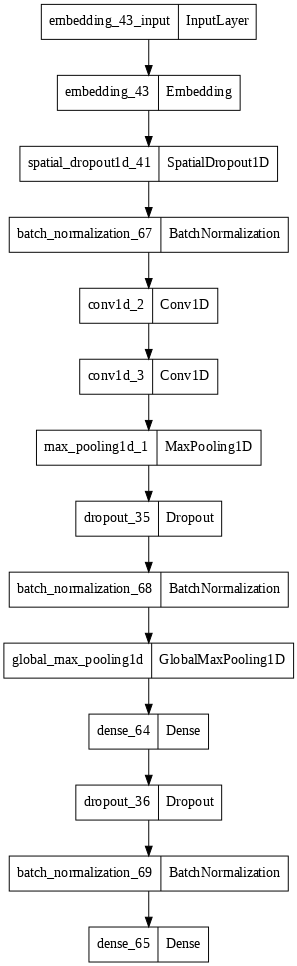

In [206]:
model_Conv_3 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Conv_3.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_Conv_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Conv_3.add(BatchNormalization())  # добавляем слой нормализации данных
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_3.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Conv_3.add(Dense(64, activation='relu')) # добавляем полносвязный слой на 64 нейрона, с функцией активации relu
model_Conv_3.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Conv_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Conv_3.summary()
print()
plot_model(model_Conv_2, dpi=70)

In [207]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Conv_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 3s 93ms/step - loss: 2.7228 - accuracy: 0.0781 - val_loss: 2.3037 - val_accuracy: 0.0784
Epoch 2/100
7/7 [==============================] - 0s 51ms/step - loss: 2.5758 - accuracy: 0.1222 - val_loss: 2.3051 - val_accuracy: 0.0784
Epoch 3/100
7/7 [==============================] - 0s 45ms/step - loss: 2.5774 - accuracy: 0.1058 - val_loss: 2.3063 - val_accuracy: 0.1307
Epoch 4/100
7/7 [==============================] - 0s 46ms/step - loss: 2.5731 - accuracy: 0.1008 - val_loss: 2.3065 - val_accuracy: 0.1046
Epoch 5/100
7/7 [==============================] - 0s 49ms/step - loss: 2.5166 - accuracy: 0.1146 - val_loss: 2.3076 - val_accuracy: 0.1046
Epoch 6/100
7/7 [==============================] - 0s 45ms/step - loss: 2.4394 - accuracy: 0.1121 - val_loss: 2.3073 - val_accuracy: 0.1046
Epoch 7/100
7/7 [==============================] - 0s 45ms/step - loss: 2.4393 - accuracy: 0.1033 - val_loss: 2.3079 - val_accuracy: 0.1046
Epoch 8/100
7/7 [===

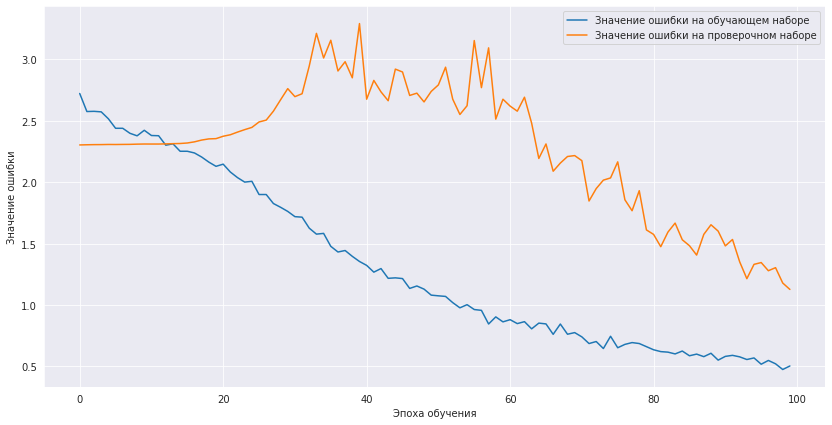

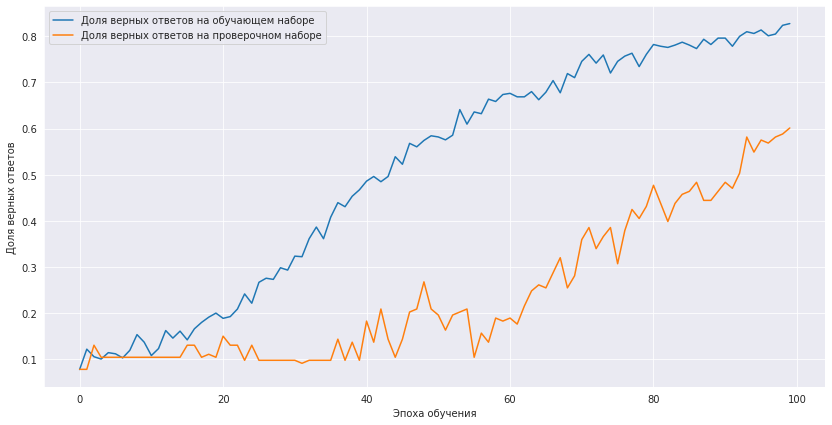

In [208]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [209]:
pred = recognizeMultiClass(model_Conv_3, xTest10Classes, "Embedding + Conv") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv

Аппендицит  распознано  38 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  25 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  86 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  50 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  50 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  57 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  40 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  89 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  75 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  91 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  60 %



# **Иссл. №20**

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 100, 50)           10000000  
                                                                 
 spatial_dropout1d_44 (Spati  (None, 100, 50)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_77 (Bat  (None, 100, 50)          200       
 chNormalization)                                                
                                                                 
 conv1d_11 (Conv1D)          (None, 96, 20)            5020      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 48, 20)           0         
 1D)                                                             
                                                     

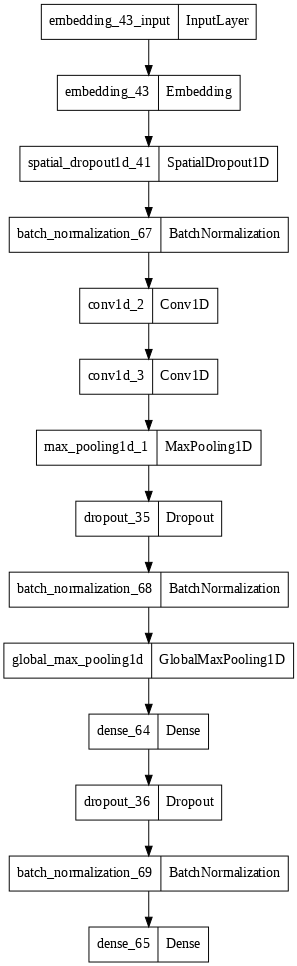

In [212]:
model_Conv_4 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Conv_4.add(Embedding(200000, 50, input_length=xLen))

model_Conv_4.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Conv_4.add(BatchNormalization())  # добавляем слой нормализации данных
model_Conv_4.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_4.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_4.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_4.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_4.add(GlobalMaxPooling1D()) # добавляем слой подвыборки/пулинга с функцией максимума(по всей длине входящей последовательности)
#modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Conv_4.add(Dense(20, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_Conv_4.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_4.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_4.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Conv_4.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Conv_4.summary()
print()
plot_model(model_Conv_2, dpi=70)

In [213]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Conv_4.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 2s 117ms/step - loss: 2.5297 - accuracy: 0.1524 - val_loss: 2.2957 - val_accuracy: 0.2157
Epoch 2/100
7/7 [==============================] - 1s 76ms/step - loss: 2.2833 - accuracy: 0.1965 - val_loss: 2.2984 - val_accuracy: 0.1307
Epoch 3/100
7/7 [==============================] - 1s 76ms/step - loss: 2.1264 - accuracy: 0.2368 - val_loss: 2.3014 - val_accuracy: 0.1895
Epoch 4/100
7/7 [==============================] - 1s 79ms/step - loss: 1.9664 - accuracy: 0.3199 - val_loss: 2.3028 - val_accuracy: 0.2157
Epoch 5/100
7/7 [==============================] - 1s 75ms/step - loss: 1.8907 - accuracy: 0.3401 - val_loss: 2.3037 - val_accuracy: 0.1503
Epoch 6/100
7/7 [==============================] - 1s 75ms/step - loss: 1.7820 - accuracy: 0.4030 - val_loss: 2.3071 - val_accuracy: 0.1176
Epoch 7/100
7/7 [==============================] - 1s 74ms/step - loss: 1.7135 - accuracy: 0.4270 - val_loss: 2.3127 - val_accuracy: 0.1046
Epoch 8/100
7/7 [==

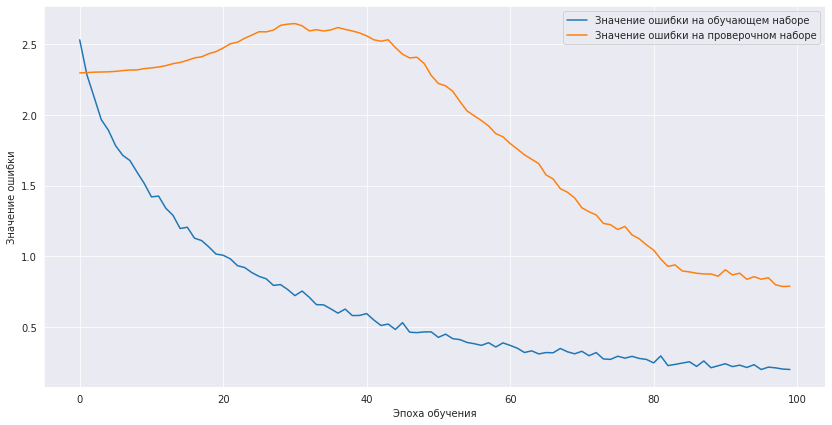

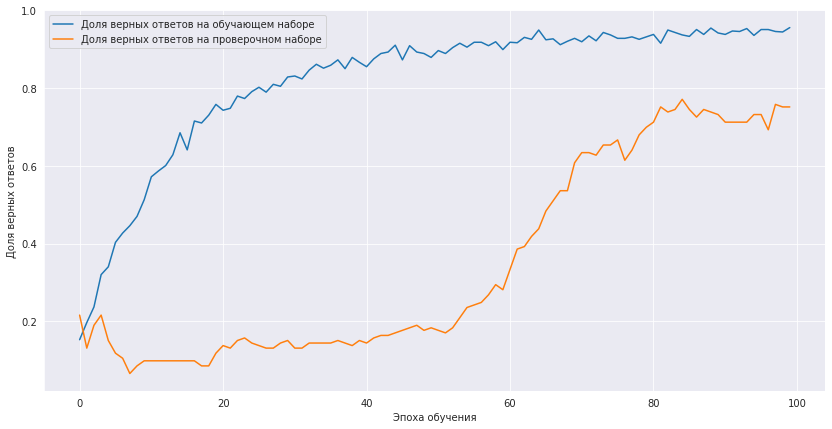

In [214]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [215]:
pred = recognizeMultiClass(model_Conv_4, xTest10Classes, "Embedding + Conv") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv

Аппендицит  распознано  69 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  37 % сеть считает, что это  Гастрит ,  распознано ВЕРНО!
Гепатит  распознано  80 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  41 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  81 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  50 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  100 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  84 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  93 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  100 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  75 %



# LSTM + Conv1D

# **Иссл. №21**

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 100, 10)           1000      
                                                                 
 spatial_dropout1d_45 (Spati  (None, 100, 10)          0         
 alDropout1D)                                                    
                                                                 
 lstm_18 (LSTM)              (None, 100, 4)            240       
                                                                 
 dense_72 (Dense)            (None, 100, 100)          500       
                                                                 
 conv1d_12 (Conv1D)          (None, 96, 20)            10020     
                                                                 
 lstm_19 (LSTM)              (None, 96, 4)             400       
                                                     

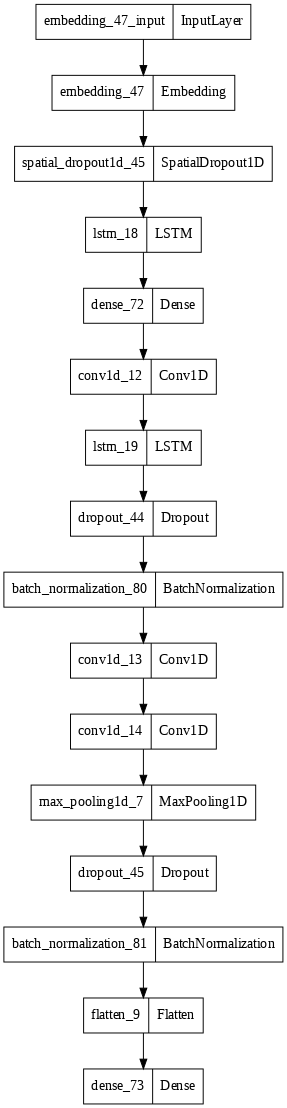

In [216]:
model_LC_1 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LC_1.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LC_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LC_1.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_1.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LC_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_1.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_1.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_LC_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_1.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_LC_1.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LC_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LC_1.summary()
print()
plot_model(model_LC_1, dpi=70)

In [217]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LC_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 8s 300ms/step - loss: 2.4929 - accuracy: 0.1272 - val_loss: 2.3034 - val_accuracy: 0.0784
Epoch 2/100
7/7 [==============================] - 1s 138ms/step - loss: 2.3305 - accuracy: 0.0970 - val_loss: 2.3035 - val_accuracy: 0.0784
Epoch 3/100
7/7 [==============================] - 1s 139ms/step - loss: 2.2484 - accuracy: 0.1763 - val_loss: 2.3039 - val_accuracy: 0.0784
Epoch 4/100
7/7 [==============================] - 1s 143ms/step - loss: 2.1122 - accuracy: 0.1914 - val_loss: 2.3035 - val_accuracy: 0.0784
Epoch 5/100
7/7 [==============================] - 1s 142ms/step - loss: 1.9436 - accuracy: 0.2418 - val_loss: 2.3038 - val_accuracy: 0.0784
Epoch 6/100
7/7 [==============================] - 1s 139ms/step - loss: 1.7222 - accuracy: 0.3451 - val_loss: 2.3033 - val_accuracy: 0.0784
Epoch 7/100
7/7 [==============================] - 1s 142ms/step - loss: 1.5782 - accuracy: 0.3929 - val_loss: 2.3037 - val_accuracy: 0.0784
Epoch 8/100
7

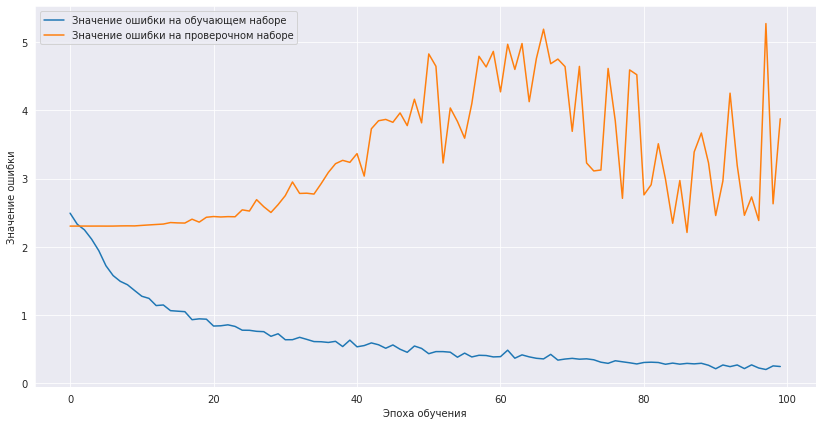

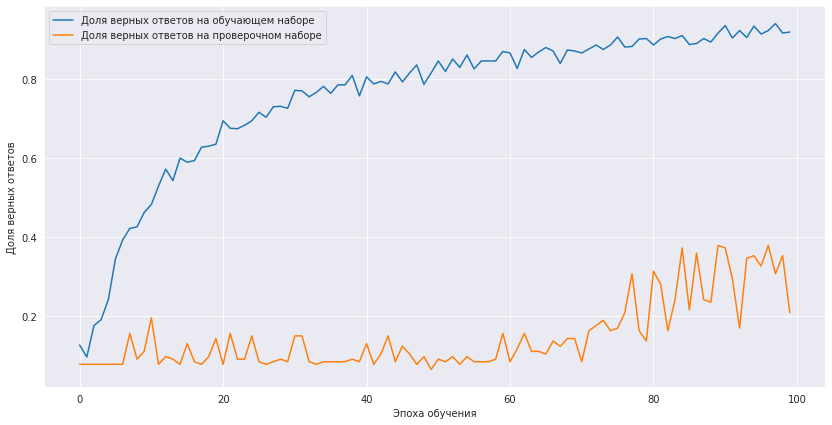

In [218]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [219]:
pred = recognizeMultiClass(model_LC_1, xTest10Classes, "Embedding + Conv + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv + LSTM

Аппендицит  распознано  38 % сеть считает, что это  Аппендицит ,  распознано ВЕРНО!
Гастрит  распознано  6 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Гепатит  распознано  0 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Дуоденит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Колит  распознано  0 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  7 % сеть считает, что это  Язва ,  распознано НЕ ВЕРНО!
Холицестит  распознано  0 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Эзофагит  распознано  68 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  18 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Язва  распознано  75 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  20 %



# **Иссл. №22**

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 100, 10)           1000      
                                                                 
 spatial_dropout1d_46 (Spati  (None, 100, 10)          0         
 alDropout1D)                                                    
                                                                 
 lstm_20 (LSTM)              (None, 100, 4)            240       
                                                                 
 dense_74 (Dense)            (None, 100, 100)          500       
                                                                 
 conv1d_15 (Conv1D)          (None, 96, 20)            10020     
                                                                 
 lstm_21 (LSTM)              (None, 96, 4)             400       
                                                     

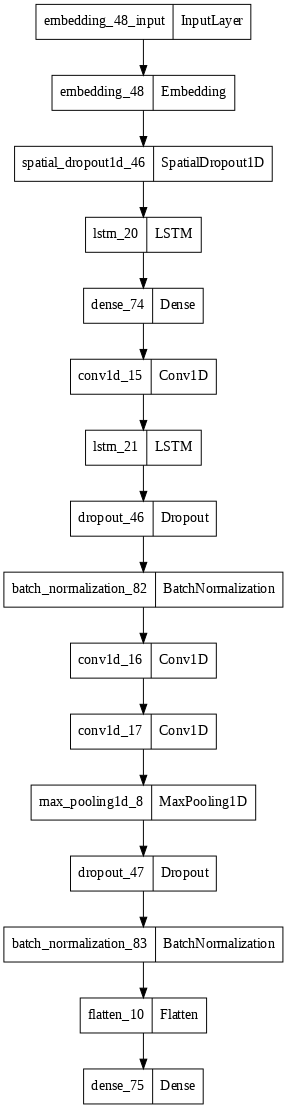

In [220]:
model_LC_2 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LC_2.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LC_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LC_2.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_2.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LC_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_2.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_2.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_2.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_LC_2.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_2.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_LC_2.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LC_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LC_2.summary()
print()
plot_model(model_LC_2, dpi=70)

In [221]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LC_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 7s 296ms/step - loss: 2.4577 - accuracy: 0.1234 - val_loss: 2.3031 - val_accuracy: 0.0784
Epoch 2/100
7/7 [==============================] - 1s 139ms/step - loss: 2.3297 - accuracy: 0.1058 - val_loss: 2.3037 - val_accuracy: 0.0784
Epoch 3/100
7/7 [==============================] - 1s 137ms/step - loss: 2.3021 - accuracy: 0.1209 - val_loss: 2.3038 - val_accuracy: 0.0784
Epoch 4/100
7/7 [==============================] - 1s 143ms/step - loss: 2.3102 - accuracy: 0.1045 - val_loss: 2.3044 - val_accuracy: 0.0784
Epoch 5/100
7/7 [==============================] - 1s 138ms/step - loss: 2.2569 - accuracy: 0.1625 - val_loss: 2.3044 - val_accuracy: 0.0784
Epoch 6/100
7/7 [==============================] - 1s 139ms/step - loss: 2.1717 - accuracy: 0.1738 - val_loss: 2.3043 - val_accuracy: 0.0784
Epoch 7/100
7/7 [==============================] - 1s 137ms/step - loss: 2.0610 - accuracy: 0.1763 - val_loss: 2.3046 - val_accuracy: 0.0784
Epoch 8/100
7

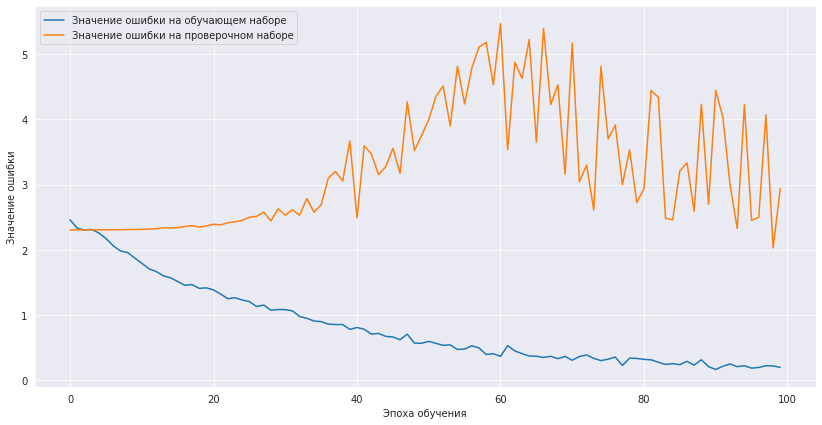

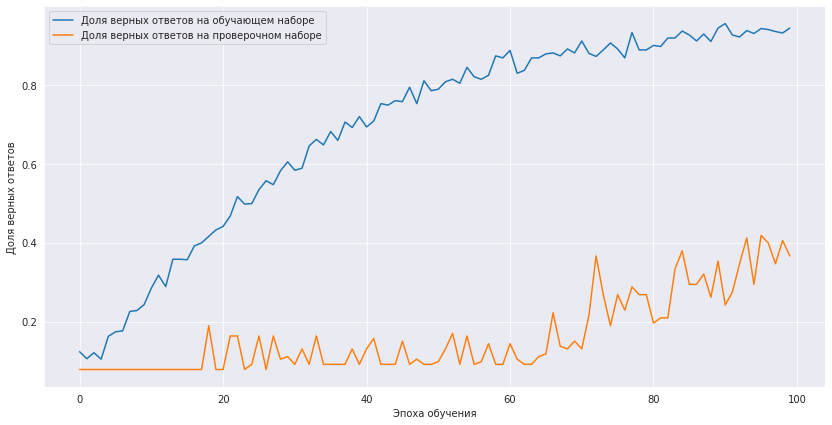

In [222]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [223]:
pred = recognizeMultiClass(model_LC_2, xTest10Classes, "Embedding + Conv + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv + LSTM

Аппендицит  распознано  23 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  6 % сеть считает, что это  Дуоденит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  100 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  50 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  12 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Панкреатит  распознано  57 % сеть считает, что это  Панкреатит ,  распознано ВЕРНО!
Холицестит  распознано  90 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  10 % сеть считает, что это  Холицестит ,  распознано НЕ ВЕРНО!
Энтерит  распознано  6 % сеть считает, что это  Гепатит ,  распознано НЕ ВЕРНО!
Язва  распознано  0 % сеть считает, что это  Дуоденит ,  распознано НЕ ВЕРНО!

Средний процент распознавания  36 %



# **Иссл. №23**

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 100, 10)           1000      
                                                                 
 spatial_dropout1d_47 (Spati  (None, 100, 10)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_18 (Conv1D)          (None, 96, 20)            1020      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 48, 20)           0         
 1D)                                                             
                                                                 
 dropout_48 (Dropout)        (None, 48, 20)            0         
                                                                 
 batch_normalization_84 (Bat  (None, 48, 20)         

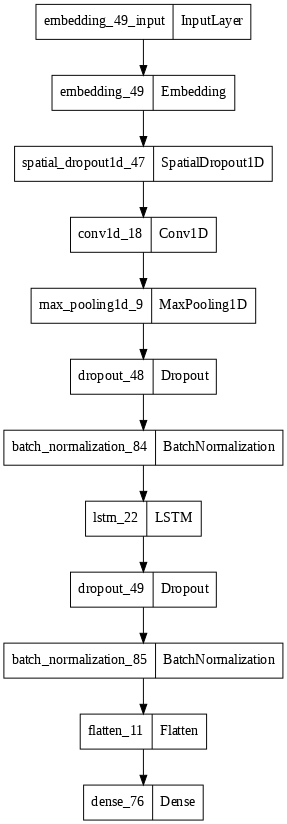

In [224]:
model_LC_3 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LC_3.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LC_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LC_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
model_LC_3.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_LC_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_3.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_3.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_LC_3.add(Dense(10, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LC_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model_LC_3.summary()
print()
plot_model(model_LC_3, dpi=70)

In [225]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LC_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(xTest, yTest))

Epoch 1/100
7/7 [==============================] - 4s 132ms/step - loss: 2.9079 - accuracy: 0.1045 - val_loss: 2.3020 - val_accuracy: 0.0784
Epoch 2/100
7/7 [==============================] - 0s 40ms/step - loss: 2.6910 - accuracy: 0.1335 - val_loss: 2.3012 - val_accuracy: 0.1111
Epoch 3/100
7/7 [==============================] - 0s 40ms/step - loss: 2.5301 - accuracy: 0.1474 - val_loss: 2.3004 - val_accuracy: 0.1176
Epoch 4/100
7/7 [==============================] - 0s 40ms/step - loss: 2.4667 - accuracy: 0.1675 - val_loss: 2.2998 - val_accuracy: 0.0850
Epoch 5/100
7/7 [==============================] - 0s 40ms/step - loss: 2.3938 - accuracy: 0.1851 - val_loss: 2.2995 - val_accuracy: 0.0980
Epoch 6/100
7/7 [==============================] - 0s 39ms/step - loss: 2.2821 - accuracy: 0.1952 - val_loss: 2.2983 - val_accuracy: 0.1699
Epoch 7/100
7/7 [==============================] - 0s 39ms/step - loss: 2.2048 - accuracy: 0.2380 - val_loss: 2.2970 - val_accuracy: 0.1765
Epoch 8/100
7/7 [==

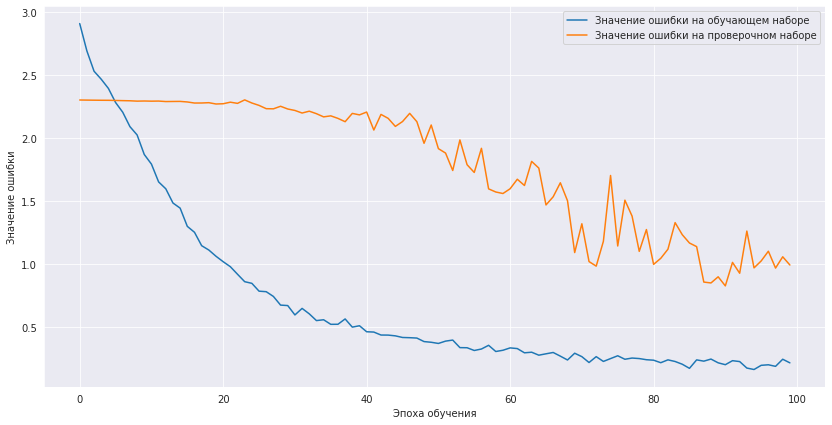

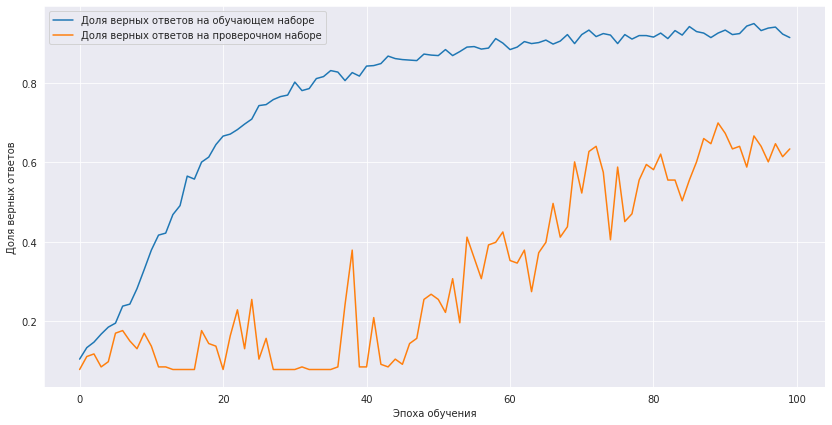

In [227]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [228]:
pred = recognizeMultiClass(model_LC_3, xTest10Classes, "Embedding + Conv + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv + LSTM

Аппендицит  распознано  23 % сеть считает, что это  Панкреатит ,  распознано НЕ ВЕРНО!
Гастрит  распознано  12 % сеть считает, что это  Дуоденит ,  распознано НЕ ВЕРНО!
Гепатит  распознано  86 % сеть считает, что это  Гепатит ,  распознано ВЕРНО!
Дуоденит  распознано  91 % сеть считает, что это  Дуоденит ,  распознано ВЕРНО!
Колит  распознано  75 % сеть считает, что это  Колит ,  распознано ВЕРНО!
Панкреатит  распознано  35 % сеть считает, что это  Аппендицит ,  распознано НЕ ВЕРНО!
Холицестит  распознано  70 % сеть считает, что это  Холицестит ,  распознано ВЕРНО!
Эзофагит  распознано  94 % сеть считает, что это  Эзофагит ,  распознано ВЕРНО!
Энтерит  распознано  56 % сеть считает, что это  Энтерит ,  распознано ВЕРНО!
Язва  распознано  83 % сеть считает, что это  Язва ,  распознано ВЕРНО!

Средний процент распознавания  63 %



**Лес деревьев**